In [1]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2022-06-09 16:10:51'

# Disregard random decorrelator sweep for now, its wrong

## 0016 is the latest one wtf

In [2]:
import mariadb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import matplotlib.ticker as ticker

%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
    })
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})
# paper config below (uncomment)

plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.size': 15,
    'figure.autolayout': True,
    'figure.figsize': (7.2,4.45),
    'axes.titlesize' : 16,
    'axes.labelsize' : 17,
    'lines.linewidth' : 2,
    'lines.markersize' : 6,
    'legend.fontsize': '13',
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    
    })

# some irrelavant config
#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [4]:
from cycler import cycler

fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.7
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))
marker_cycler = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["none", "none", "none", "none", "none", "none", "none"]) +
                 cycler(marker=["4", "2", "3", "1", "+", "x", "."]))
standard_cycler = cycler("color", ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"])
plt.rc("axes", prop_cycle=standard_cycler)


In [5]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run_id", timestep_col_name="episode", local=False, gc=False, gc2=False):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            if local:
                    self.conn = mariadb.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            elif gc:
                self.conn = mariadb.connect(user='rlai',
                                            password=os.environ['gcpswd'],
                                            host='35.203.104.151',
                                            database=db_name)
            elif gc2:
                self.conn = mariadb.connect(user='narval',
                                            password=os.environ['narvalpswd'],
                                            host='34.152.53.247',
                                            database=db_name)
            else:
                # requires ssh tunnel to ccdb
                self.conn = mariadb.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3307,
                                            database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [6]:
db1 = DbAccessor('hshah1_0302_no_decor_n2_decor_sweep', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db1.conn)

,name,age_restriction,min_estimation_period,n2_decorrelate,n_distractors,n_inputs,n_learner_features,n_target_features,random_decorrelate,random_replacement,replace_every,replace_perc,seed,step_size,steps,sum_features,run
0,0302_no_decor_n2_decor_sweep,0,5000,0,0,5,50,10,0,0,5000,0.2,0,0.10000,1000001,0,0
1,0302_no_decor_n2_decor_sweep,0,5000,1,0,5,50,10,0,0,5000,0.2,0,0.10000,1000001,0,1
2,0302_no_decor_n2_decor_sweep,0,5000,0,0,5,50,50,0,0,5000,0.2,0,0.10000,1000001,0,2
3,0302_no_decor_n2_decor_sweep,0,5000,1,0,5,50,50,0,0,5000,0.2,0,0.10000,1000001,0,3
4,0302_no_decor_n2_decor_sweep,0,5000,0,0,5,50,500,0,0,5000,0.2,0,0.10000,1000001,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0302_no_decor_n2_decor_sweep,0,5000,1,0,5,50,10,0,0,5000,0.2,9,0.00001,1000001,0,1195
1196,0302_no_decor_n2_decor_sweep,0,5000,0,0,5,50,50,0,0,5000,0.2,9,0.00001,1000001,0,1196
1197,0302_no_decor_n2_decor_sweep,0,5000,1,0,5,50,50,0,0,5000,0.2,9,0.00001,1000001,0,1197
1198,0302_no_decor_n2_decor_sweep,0,5000,0,0,5,50,500,0,0,5000,0.2,9,0.00001,1000001,0,1198


In [7]:
db2 = DbAccessor('hshah1_0310_random_decor_sweep_retry', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db2.conn)

,name,age_restriction,min_estimation_period,n2_decorrelate,n_distractors,n_inputs,n_learner_features,n_target_features,random_decorrelate,random_replacement,replace_every,replace_perc,seed,step_size,steps,sum_features,run
0,0310_random_decor_sweep_retry,0,1000,0,0,5,50,10,1,0,5000,0.2,0,0.10000,1000001,0,0
1,0310_random_decor_sweep_retry,0,5000,0,0,5,50,10,1,0,5000,0.2,0,0.10000,1000001,0,1
2,0310_random_decor_sweep_retry,0,10000,0,0,5,50,10,1,0,5000,0.2,0,0.10000,1000001,0,2
3,0310_random_decor_sweep_retry,0,20000,0,0,5,50,10,1,0,5000,0.2,0,0.10000,1000001,0,3
4,0310_random_decor_sweep_retry,0,1000,0,0,5,50,50,1,0,5000,0.2,0,0.10000,1000001,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0310_random_decor_sweep_retry,0,20000,0,0,5,50,50,1,0,5000,0.2,9,0.00001,1000001,0,2395
2396,0310_random_decor_sweep_retry,0,1000,0,0,5,50,500,1,0,5000,0.2,9,0.00001,1000001,0,2396
2397,0310_random_decor_sweep_retry,0,5000,0,0,5,50,500,1,0,5000,0.2,9,0.00001,1000001,0,2397
2398,0310_random_decor_sweep_retry,0,10000,0,0,5,50,500,1,0,5000,0.2,9,0.00001,1000001,0,2398


In [8]:
db3 = DbAccessor('hshah1_0311_random_thresh_decor_sweep', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db3.conn)

,name,age_restriction,min_estimation_period,n2_decorrelate,n_distractors,n_inputs,n_learner_features,n_target_features,random_decorrelate,random_replacement,random_thresh_decorrelate,replace_every,replace_perc,seed,step_size,steps,sum_features,run
0,0311_random_thresh_decor_sweep,0,1000,0,0,5,50,10,0,0,1,5000,0.2,0,0.10000,1000001,0,0
1,0311_random_thresh_decor_sweep,0,5000,0,0,5,50,10,0,0,1,5000,0.2,0,0.10000,1000001,0,1
2,0311_random_thresh_decor_sweep,0,10000,0,0,5,50,10,0,0,1,5000,0.2,0,0.10000,1000001,0,2
3,0311_random_thresh_decor_sweep,0,20000,0,0,5,50,10,0,0,1,5000,0.2,0,0.10000,1000001,0,3
4,0311_random_thresh_decor_sweep,0,1000,0,0,5,50,50,0,0,1,5000,0.2,0,0.10000,1000001,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0311_random_thresh_decor_sweep,0,20000,0,0,5,50,50,0,0,1,5000,0.2,9,0.00001,1000001,0,2395
2396,0311_random_thresh_decor_sweep,0,1000,0,0,5,50,500,0,0,1,5000,0.2,9,0.00001,1000001,0,2396
2397,0311_random_thresh_decor_sweep,0,5000,0,0,5,50,500,0,0,1,5000,0.2,9,0.00001,1000001,0,2397
2398,0311_random_thresh_decor_sweep,0,10000,0,0,5,50,500,0,0,1,5000,0.2,9,0.00001,1000001,0,2398


In [9]:
def plt_individual(comment, NSTEPS, min_steps, db, colors, label=None, condition=[], table='test_metrics', plot_conf=True, linestyle='-', pkey_col = "run_id", nocomment=False, nolabel=False, linewidth=None, col=None, alpha=1):
    #NSTEPS : number of entries
    if label==None:
        label=comment
    if col is None:
        if table == 'training_metrics':
            col = 'running_acc'
        elif table == 'error_table' or table == "test_accuracy":
            col = 'error'
        else:
            col = 'acc'
    suitable_runs = pd.read_sql(f'select {pkey_col} from {table} group by {pkey_col} having max({db.timestep_col_name}) > {min_steps}', db.conn).values
    #suitable_runs = [s for s in suitable_runs if len(db.get_table(table, s[0], col).values.reshape(-1)) >= NSTEPS]
        
    runs = []
    invalid_count = 0
    if nocomment:
        # too lazy
        if condition == []:
            r = pd.read_sql(f'select {pkey_col} from runs ', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} ', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} ', db.conn).values
        elif len(condition) == 3:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]}', db.conn).values
        elif len(condition) == 4:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]}', db.conn).values
        elif len(condition) == 5:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]} and {condition[4][0]} = {condition[4][1]}', db.conn).values
        if len(r) !=0:
            runs = r

    runs = [r for r in runs if len(db.get_table(table, r[0], col).values.reshape(-1)) >= NSTEPS]
    if len(runs) == 0:
        print("\t 0 runs for ", condition)
        return False
    else:
        print(f'\t Found {len(runs)} valid runs for {condition}')

    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
    acc_mean = np.mean(acc_all, axis=0)
    
    x_axis = db.get_table(table, run[0], col).index[:NSTEPS].to_numpy()
    if linewidth is None:
        linewidth = plt.rcParams["lines.linewidth"]
        if linestyle == ":":
            linewidth = plt.rcParams["lines.linewidth"]/2
    
    for i, run in enumerate(runs):
        plt.plot(x_axis, acc_all[i,:], label=f"run {i}", color=colors[i], linestyle=linestyle, linewidth=linewidth, alpha=alpha)
    return True

In [10]:
def plt_individual_corr(comment, NSTEPS, min_steps, db, colors, label=None, condition=[], table='test_metrics', plot_conf=True, linestyle='-', pkey_col = "run_id", nocomment=False, nolabel=False, linewidth=None, col=None, alpha=1, features=50):
    #NSTEPS : number of entries
    if label==None:
        label=comment
    if col is None:
        if table == 'training_metrics':
            col = 'running_acc'
        elif table == 'error_table' or table == "test_accuracy":
            col = 'error'
        else:
            col = 'acc'
    suitable_runs = pd.read_sql(f'select {pkey_col} from {table} group by {pkey_col} having max({db.timestep_col_name}) > {min_steps}', db.conn).values
    #suitable_runs = [s for s in suitable_runs if len(db.get_table(table, s[0], col).values.reshape(-1)) >= NSTEPS]
        
    runs = []
    invalid_count = 0
    if nocomment:
        # too lazy
        if condition == []:
            r = pd.read_sql(f'select {pkey_col} from runs ', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} ', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} ', db.conn).values
        elif len(condition) == 3:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]}', db.conn).values
        elif len(condition) == 4:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]}', db.conn).values
        elif len(condition) == 5:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]} and {condition[4][0]} = {condition[4][1]}', db.conn).values
        if len(r) !=0:
            runs = r

    runs = [r for r in runs if len(db.get_table(table, r[0], col).values.reshape(-1)) >= NSTEPS]
    if len(runs) == 0:
        print("\t 0 runs for ", condition)
        return False
    else:
        print(f'\t Found {len(runs)} valid runs for {condition}')

    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
    acc_mean = np.mean(acc_all, axis=0)
    
    x_axis = db.get_table(table, run[0], col).index[:NSTEPS].to_numpy()
    if linewidth is None:
        linewidth = plt.rcParams["lines.linewidth"]
        if linestyle == ":":
            linewidth = plt.rcParams["lines.linewidth"]/2
    
    for i, run in enumerate(runs):
        plt.plot(x_axis, 100*acc_all[i,:]/features, label=f"run {i}", color=colors[i], linestyle=linestyle, linewidth=linewidth, alpha=alpha)
    return True

In [11]:
def plt_with_err_corr(comment, NSTEPS, min_steps, db, color, label=None, condition=[], table='test_metrics', plot_conf=True, linestyle='-', pkey_col = "run_id", nocomment=False, nolabel=False, linewidth=None, col=None, features=50):
    #NSTEPS : number of entries
    if label==None:
        label=comment
    if col is None:
        if table == 'training_metrics':
            col = 'running_acc'
        elif table == 'error_table' or table == "test_accuracy":
            col = 'error'
        else:
            col = 'acc'
    suitable_runs = pd.read_sql(f'select {pkey_col} from {table} group by {pkey_col} having max({db.timestep_col_name}) > {min_steps}', db.conn).values
    #suitable_runs = [s for s in suitable_runs if len(db.get_table(table, s[0], col).values.reshape(-1)) >= NSTEPS]
        
    runs = []
    invalid_count = 0
    if nocomment:
        # too lazy
        if condition == []:
            r = pd.read_sql(f'select {pkey_col} from runs ', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} ', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} ', db.conn).values
        elif len(condition) == 3:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]}', db.conn).values
        elif len(condition) == 4:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]}', db.conn).values
        elif len(condition) == 5:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]} and {condition[4][0]} = {condition[4][1]}', db.conn).values
        if len(r) !=0:
            runs = r

    runs = [r for r in runs if len(db.get_table(table, r[0], col).values.reshape(-1)) >= NSTEPS]
    if len(runs) == 0:
        print("\t 0 runs for ", condition)
        return False
    else:
        print(f'\t Found {len(runs)} valid runs for {condition}')

        
    acc_sums = 0
    total_runs = 0
    for run in runs:
        acc_sums += db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
        total_runs += 1
    mean_acc = acc_sums / total_runs



    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  100*db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1) / features
    acc_mean = np.mean(acc_all, axis=0)
    acc_std = np.std(acc_all, axis=0)/np.sqrt(total_runs)
    x_axis = db.get_table(table, run[0], col).index[:NSTEPS].to_numpy()
    #plt.errorbar(x_axis, acc_mean, yerr=acc_std*1.96, label=f"{label} | runs: {total_runs} | invalid: {invalid_count}", color=color)
    if linewidth is None:
        linewidth = plt.rcParams["lines.linewidth"]
        if linestyle == ":":
            linewidth = plt.rcParams["lines.linewidth"]/2
            
    if nolabel:
        plt.plot(x_axis, acc_mean, color=color, linestyle=linestyle, linewidth=linewidth)
    else:
        plt.plot(x_axis, acc_mean, label=f"{label} | valid runs: {total_runs}", color=color, linestyle=linestyle, linewidth=linewidth)
        #plt.plot(x_axis, acc_mean, label=f"{label}", color=color, linestyle=linestyle, linewidth=linewidth)
    if plot_conf:
        plt.fill_between(x_axis, acc_mean-acc_std*1.96, acc_mean+acc_std*1.96, alpha=0.16, color=color, edgecolor=None)
    return True

In [12]:
def plt_with_err(comment, NSTEPS, min_steps, db, color, label=None, condition=[], table='test_metrics', plot_conf=True, linestyle='-', pkey_col = "run_id", nocomment=False, nolabel=False, linewidth=None, col=None):
    #NSTEPS : number of entries
    if label==None:
        label=comment
    if col is None:
        if table == 'training_metrics':
            col = 'running_acc'
        elif table == 'error_table' or table == "test_accuracy":
            col = 'error'
        else:
            col = 'acc'
    suitable_runs = pd.read_sql(f'select {pkey_col} from {table} group by {pkey_col} having max({db.timestep_col_name}) > {min_steps}', db.conn).values
    #suitable_runs = [s for s in suitable_runs if len(db.get_table(table, s[0], col).values.reshape(-1)) >= NSTEPS]
        
    runs = []
    invalid_count = 0
    if nocomment:
        # too lazy
        if condition == []:
            r = pd.read_sql(f'select {pkey_col} from runs ', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} ', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} ', db.conn).values
        elif len(condition) == 3:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]}', db.conn).values
        elif len(condition) == 4:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]}', db.conn).values
        elif len(condition) == 5:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]} and {condition[4][0]} = {condition[4][1]}', db.conn).values
        if len(r) !=0:
            runs = r

    runs = [r for r in runs if len(db.get_table(table, r[0], col).values.reshape(-1)) >= NSTEPS]
    if len(runs) == 0:
        print("\t 0 runs for ", condition)
        return False
    else:
        print(f'\t Found {len(runs)} valid runs for {condition}')

        
    acc_sums = 0
    total_runs = 0
    for run in runs:
        acc_sums += db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
        total_runs += 1
    mean_acc = acc_sums / total_runs



    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
    acc_mean = np.mean(acc_all, axis=0)
    acc_std = np.std(acc_all, axis=0)/np.sqrt(total_runs)
    x_axis = db.get_table(table, run[0], col).index[:NSTEPS].to_numpy()
    #plt.errorbar(x_axis, acc_mean, yerr=acc_std*1.96, label=f"{label} | runs: {total_runs} | invalid: {invalid_count}", color=color)
    if linewidth is None:
        linewidth = plt.rcParams["lines.linewidth"]
        if linestyle == ":":
            linewidth = plt.rcParams["lines.linewidth"]/2
    if nolabel:
        plt.plot(x_axis, acc_mean, color=color, linestyle=linestyle, linewidth=linewidth)
    else:
        plt.plot(x_axis, acc_mean, label=f"{label} | valid runs: {total_runs}", color=color, linestyle=linestyle, linewidth=linewidth)
        #plt.plot(x_axis, acc_mean, label=f"{label}", color=color, linestyle=linestyle, linewidth=linewidth)
    if plot_conf:
        plt.fill_between(x_axis, acc_mean-acc_std*1.96, acc_mean+acc_std*1.96, alpha=0.16, color=color, edgecolor=None)
    return True

In [13]:
def plt_with_err_summary(db, color, label=None, condition=[], table='test_metrics', plot_conf=True, linestyle='-', pkey_col = "run_id", nocomment=False, nolabel=False, linewidth=None, col=None):
    #NSTEPS : number of entries
    if label==None:
        label=comment        
    runs = []
    invalid_count = 0
    if nocomment:
        # too lazy
        if condition == []:
            r = pd.read_sql(f'select {pkey_col} from runs ', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} ', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} ', db.conn).values
        elif len(condition) == 3:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]}', db.conn).values
        elif len(condition) == 4:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]}', db.conn).values
        elif len(condition) == 5:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]} and {condition[4][0]} = {condition[4][1]}', db.conn).values
        if len(r) !=0:
            runs = r
    if len(runs) == 0:
        print("\t 0 runs for ", condition)
        return False
    else:
        print(f'\t Found {len(runs)} valid runs for {condition}')

        

    acc_sums = 0
    total_runs = 0
    for run in runs:
        acc_sums += pd.read_sql(f'select final_error from summary_table where run={run}', db1.conn).values[0][0]
        total_runs += 1
    mean_acc = acc_sums / total_runs



    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
    acc_mean = np.mean(acc_all, axis=0)
    acc_std = np.std(acc_all, axis=0)/np.sqrt(total_runs)
    x_axis = db.get_table(table, run[0], col).index[:NSTEPS].to_numpy()
    #plt.errorbar(x_axis, acc_mean, yerr=acc_std*1.96, label=f"{label} | runs: {total_runs} | invalid: {invalid_count}", color=color)
    if linewidth is None:
        linewidth = plt.rcParams["lines.linewidth"]
        if linestyle == ":":
            linewidth = plt.rcParams["lines.linewidth"]/2
    if nolabel:
        plt.plot(x_axis, acc_mean, color=color, linestyle=linestyle, linewidth=linewidth)
    else:
        plt.plot(x_axis, acc_mean, label=f"{label} | valid runs: {total_runs}", color=color, linestyle=linestyle, linewidth=linewidth)
        #plt.plot(x_axis, acc_mean, label=f"{label}", color=color, linestyle=linestyle, linewidth=linewidth)
    if plot_conf:
        plt.fill_between(x_axis, acc_mean-acc_std*1.96, acc_mean+acc_std*1.96, alpha=0.16, color=color, edgecolor=None)
    return True

In [36]:
values[:,0].astype('str')

array(['1e-05', '3e-05', '5e-05', '8e-05', '0.0001', '0.0003', '0.0005',
       '0.0007', '0.0009', '0.001', '0.003', '0.005', '0.007', '0.009',
       '0.01', '0.03'], dtype='<U32')

# No decorrelator, only mag tester

           [1e-05]                      10                                                         [11.826073, 5.112636, 21.196041, 24.728735, 8.90892, 10.527785, 17.692438, 6.764661, 13.626142, 20.551027]                                                 14.09345      10    
           [3e-05]                      10                                                         [8.088432, 2.433049, 10.935179, 12.414628, 6.741334, 7.163142, 10.613671, 4.582699, 11.378344, 10.472334]                                                  8.48228       10    
           [5e-05]                      10                                                           [5.9158, 2.173203, 11.214944, 8.401433, 5.611787, 4.779065, 10.441236, 3.948613, 7.585578, 11.200734]                                                    7.12724       10    
           [8e-05]                      10                                                           [4.265765, 2.43891, 9.624631, 8.382468, 3.717324, 5.254918, 12.383207, 3.1

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      10                                                                                                             []                                                                                                       nan         0     
            [0.07]                      10                                                                                                             []                                                                                                       nan         0     
            [0.09]                      10                                                                                                             []                                                                                                       nan         0     


            [0.1]                       10                                                                                                             []                                                                                                       nan         0     


           [1e-05]                      50                                                      [94.550041, 120.5336, 94.957817, 145.992233, 72.486679, 83.407089, 100.187569, 86.150574, 110.50737, 115.109444]                                             102.38824      10    
           [3e-05]                      50                                                       [80.602089, 97.505142, 64.786743, 82.099388, 63.490185, 59.688126, 86.372391, 72.163353, 72.247452, 83.894356]                                               76.28492      10    
           [5e-05]                      50                                                       [62.129272, 78.094543, 77.964783, 80.881859, 64.210472, 60.613079, 71.833626

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      50                                                                                                             []                                                                                                       nan         0     
            [0.07]                      50                                                                                                             []                                                                                                       nan         0     
            [0.09]                      50                                                                                                             []                                                                                                       nan         0     


            [0.1]                       50                                                                                                             []                                                                                                       nan         0     


           [1e-05]                     500                                                [894.404114, 1172.989746, 936.354431, 825.093323, 1080.884155, 792.520264, 910.368347, 1048.878662, 929.43634, 1025.043945]                                        961.59733      10    
           [3e-05]                     500                                                  [697.022095, 785.466431, 686.942993, 828.23645, 841.608887, 710.047913, 802.956543, 755.051025, 711.179993, 727.170776]                                          754.56831      10    
           [5e-05]                     500                                                  [626.658081, 698.742188, 767.091614, 767.490356, 876.160889, 688.099915, 627.6036

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                     500                                                                                                             []                                                                                                       nan         0     
            [0.07]                     500                                                                                                             []                                                                                                       nan         0     
            [0.09]                     500                                                                                                             []                                                                                                       nan         0     


            [0.1]                      500                                                                                                             []                                                                                                       nan         0     




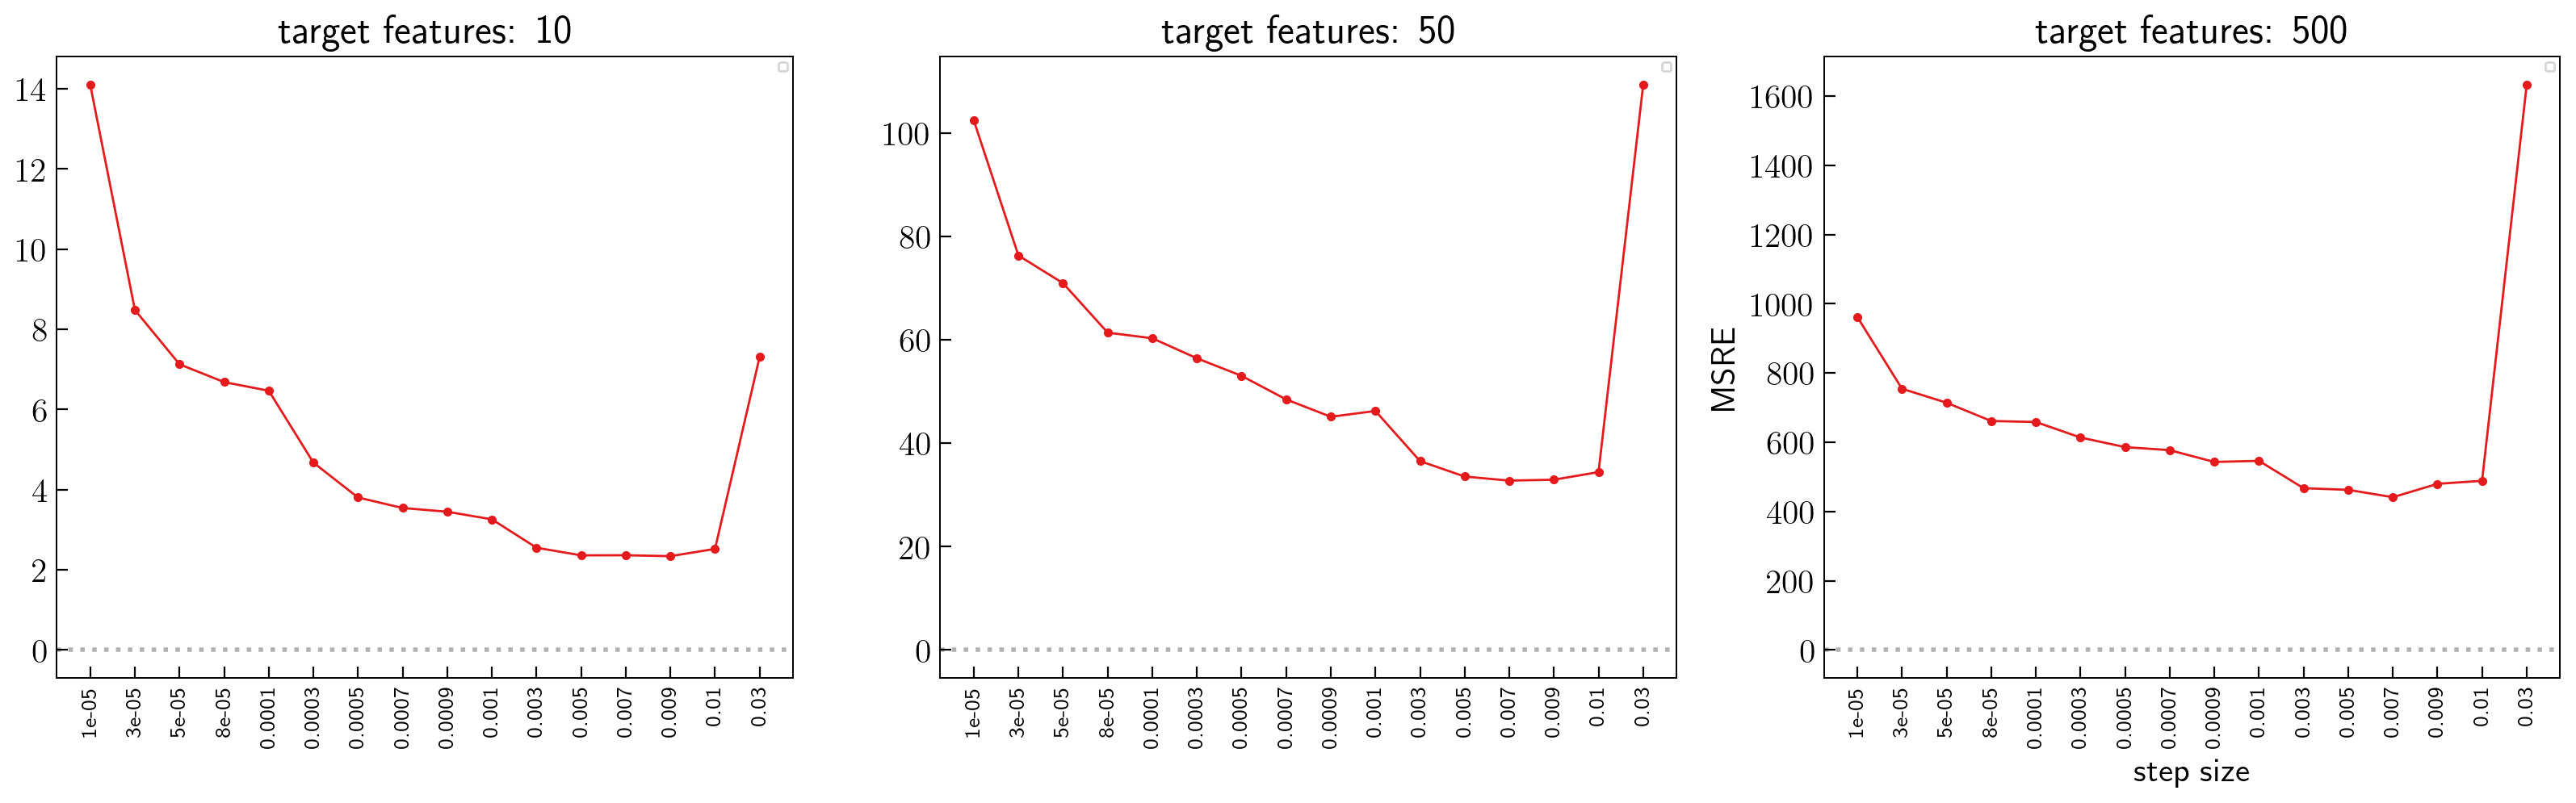

In [42]:
db=db1
total_runs_per_config = 10
markers = ['.',8,'s','p','*','h', 1,2,3,4]
marker_idx = 0
i = 0
j = 0

fig, axs = plt.subplots(1,3, figsize=(20,5), dpi=200)
plt.xlabel('step size')
plt.ylabel('MSRE')
plt.xscale('linear')
plt.xticks(rotation=90)
plt.xticks(fontsize= 5)
#fig.axes[0].set_ylim(bottom=0.002, top=0.02)
#legend = plt.legend(prop={'size': 10})
#frame = legend.get_frame()
#frame.set_linewidth(0.6)
#frame.set_boxstyle('Square')
#print(f'{"params" :^15}{"features" :^8} {"std_cap" :^10} {"all_errors":^200} {"mean" :^10} {"total runs" :^10}')
for n_target_features in [10,50,500]:
    colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']
    color_idx = 0
    mean_errors = []
    runs = pd.read_sql(f'select run, step_size from runs where n_target_features={n_target_features} and n2_decorrelate={0}', db.conn)
    p1 = np.unique(runs.values[:,1])
    for p in p1:
        p = [p]
        all_errors = []
        r = runs[(runs["step_size"] == p[0])]
        for run in r["run"].values:
            errors_list = pd.read_sql(f'select error from error_table where run={run}', db.conn).values
            if len(errors_list) >= 200:
                all_errors.append(errors_list[199][0])
        all_errors = list(filter(lambda v: v==v, all_errors))
        if len(all_errors) >= total_runs_per_config:
            mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
        print(f'{str(p) :^30} {n_target_features :^20} {str(all_errors) :^200} {np.mean(all_errors) :^10.5f} {len(all_errors) :^10}')
    #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
    r["run"].values
    mean_errors = np.array(mean_errors)

    values = mean_errors
    axs[i].plot(values[:,0].astype('str'), values[:,1], label=f"", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
    #axs[j].set_ylim(bottom=0.002, top=0.02)
    axs[i].axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)
    axs[i].legend(prop={'size': 5})
    axs[i].set_title(f"target features: {n_target_features}")
    axs[i].set_xticks(values[:,0].astype(str))
    axs[i].set_xticklabels(values[:,0], rotation=90, fontsize=10)
    color_idx += 1
    i+=1
    print("\n")
    if j == 2:
        j=0
        i+=1
j+=1
i=0

plt.show()

           [1e-05]                      10                                                                                   [0.78, 0.8, 0.78, 0.8, 0.8, 0.78, 0.76, 0.8, 0.8, 0.8]                                                                           0.79000       10    
           [3e-05]                      10                                                                                    [0.8, 0.78, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.78, 0.8]                                                                            0.79600       10    
           [5e-05]                      10                                                                                    [0.8, 0.76, 0.8, 0.78, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]                                                                            0.79400       10    
           [8e-05]                      10                                                                                   [0.8, 0.8, 0.8, 0.78, 0.8, 0.76, 0.78, 0.8, 0.78, 

            [0.1]                       10                                                                                [0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98]                                                                        0.98000       10    


           [1e-05]                      50                                                                                   [0.78, 0.8, 0.78, 0.8, 0.8, 0.8, 0.8, 0.8, 0.78, 0.8]                                                                            0.79400       10    
           [3e-05]                      50                                                                                    [0.8, 0.8, 0.8, 0.8, 0.78, 0.8, 0.8, 0.8, 0.8, 0.8]                                                                             0.79800       10    
           [5e-05]                      50                                                                                     [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 

            [0.1]                       50                                                                                [0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98]                                                                        0.98000       10    


           [1e-05]                     500                                                                                    [0.8, 0.78, 0.76, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]                                                                            0.79400       10    
           [3e-05]                     500                                                                                    [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.76, 0.8, 0.8, 0.74]                                                                            0.79000       10    
           [5e-05]                     500                                                                                    [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.78, 0.8, 

            [0.1]                      500                                                                                [0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98]                                                                        0.98000       10    




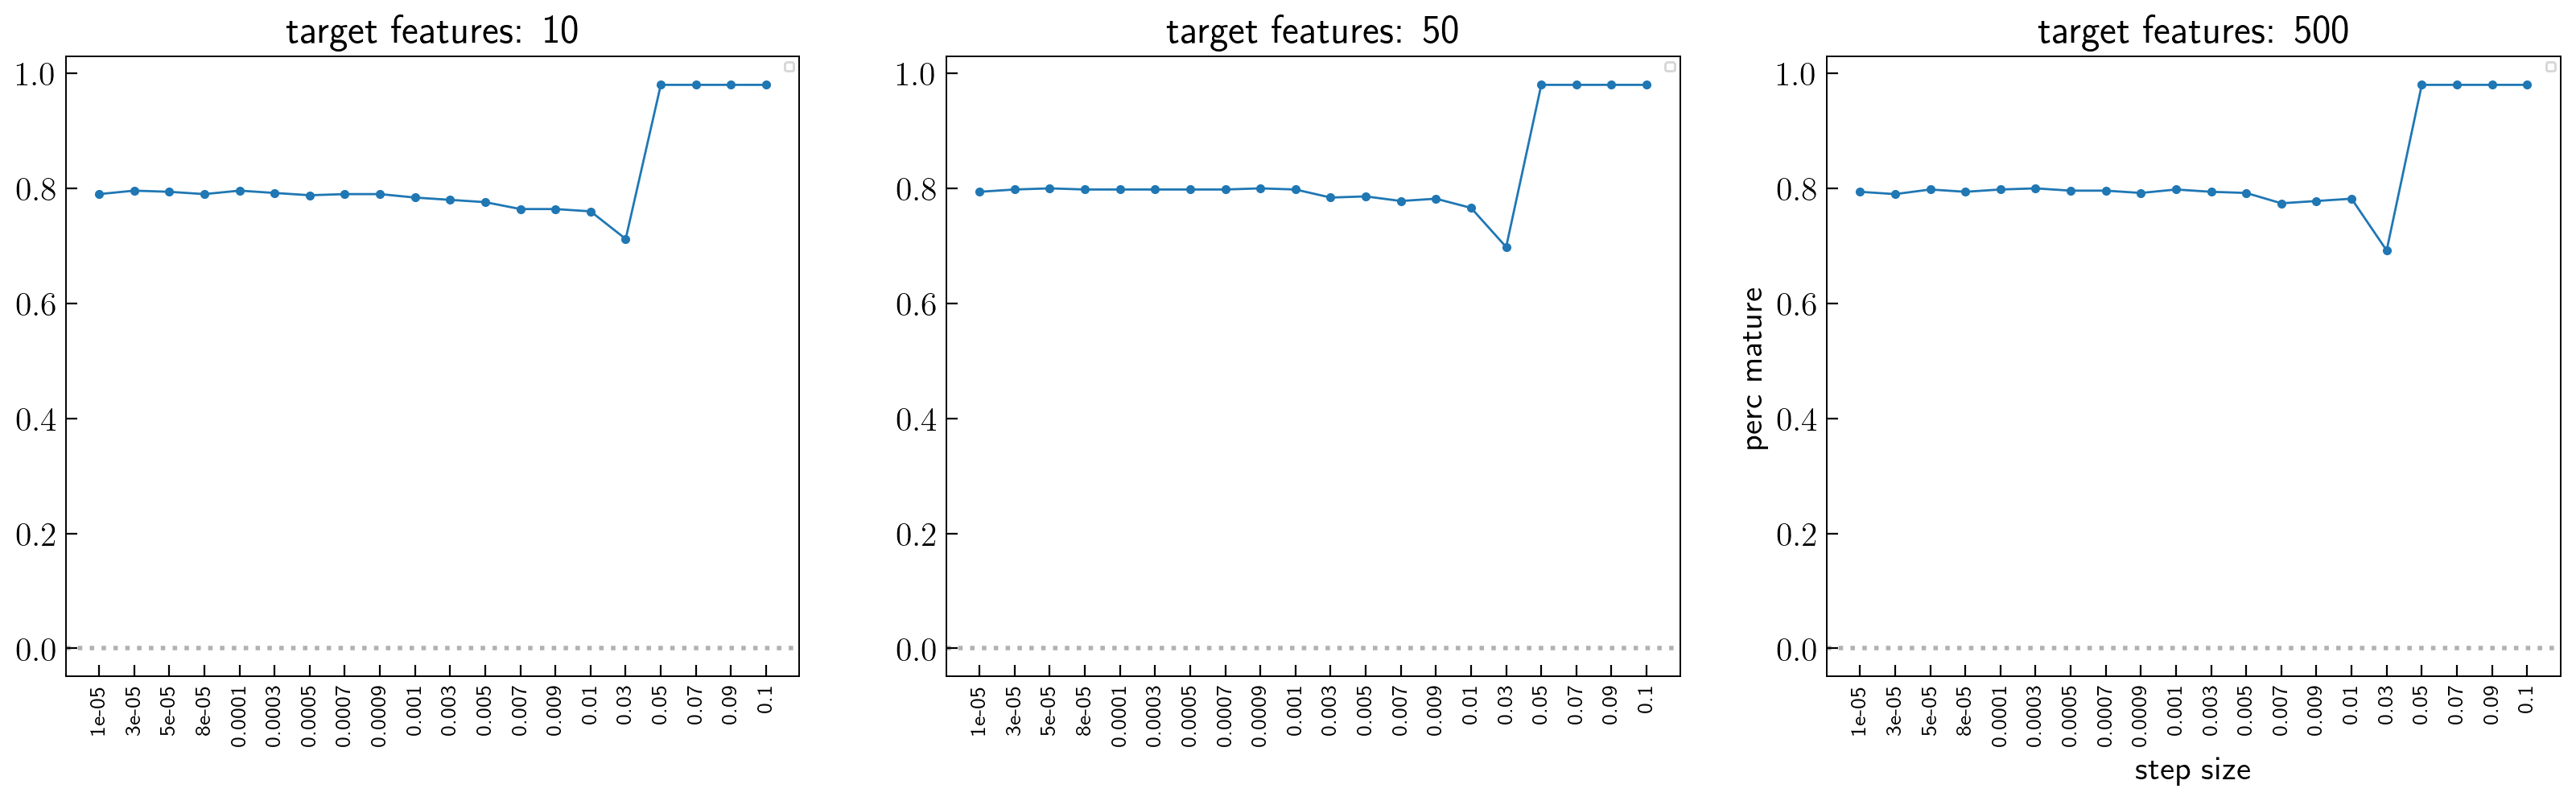

In [83]:
db=db1
total_runs_per_config = 10
markers = ['.',8,'s','p','*','h', 1,2,3,4]
marker_idx = 0
i = 0
j = 0

fig, axs = plt.subplots(1,3, figsize=(20,5), dpi=200)
plt.xlabel('step size')
plt.ylabel('perc mature')
plt.xscale('linear')
plt.xticks(rotation=90)
plt.xticks(fontsize= 5)
#fig.axes[0].set_ylim(bottom=0.002, top=0.02)
#legend = plt.legend(prop={'size': 10})
#frame = legend.get_frame()
#frame.set_linewidth(0.6)
#frame.set_boxstyle('Square')
#print(f'{"params" :^15}{"features" :^8} {"std_cap" :^10} {"all_errors":^200} {"mean" :^10} {"total runs" :^10}')
for n_target_features in [10,50,500]:
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
    color_idx = 0
    mean_errors = []
    runs = pd.read_sql(f'select run, step_size from runs where n_target_features={n_target_features} and n2_decorrelate={0}', db.conn)
    p1 = np.unique(runs.values[:,1])
    for p in p1:
        p = [p]
        all_errors = []
        r = runs[(runs["step_size"] == p[0])]
        for run in r["run"].values:
            errors_list = pd.read_sql(f'select n_mature/50 from error_table where run={run} order by step desc limit 1', db.conn).values
            all_errors.append(errors_list[0][0])
        all_errors = list(filter(lambda v: v==v, all_errors))
        if len(all_errors) >= total_runs_per_config:
            mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
        print(f'{str(p) :^30} {n_target_features :^20} {str(all_errors) :^200} {np.mean(all_errors) :^10.5f} {len(all_errors) :^10}')
    #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
    r["run"].values
    mean_errors = np.array(mean_errors)

    values = mean_errors
    axs[i].plot(values[:,0].astype('str'), values[:,1], label=f"", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
    #axs[j].set_ylim(bottom=0.002, top=0.02)
    axs[i].axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)
    axs[i].legend(prop={'size': 5})
    axs[i].set_title(f"target features: {n_target_features}")
    axs[i].set_xticks(values[:,0].astype(str))
    axs[i].set_xticklabels(values[:,0], rotation=90, fontsize=10)
    color_idx += 1
    i+=1
    print("\n")
    if j == 2:
        j=0
        i+=1
j+=1
i=0

plt.show()

           [1e-05]                      10                                                                 [51.2807, 57.4986, 56.4088, 67.4983, 59.9985, 69.229, 60.5247, 62.4984, 57.4986, 72.4982]                                                          61.49338      10    
           [3e-05]                      10                                                                 [59.9985, 64.1009, 44.9989, 37.4991, 57.4986, 64.9984, 54.9986, 54.9986, 48.7167, 47.4988]                                                         53.53071      10    
           [5e-05]                      10                                                                 [44.9989, 44.7357, 39.999, 51.2807, 57.4986, 44.9989, 42.4989, 57.4986, 37.4991, 37.4991]                                                          45.85075      10    
           [8e-05]                      10                                                                 [59.9985, 54.9986, 27.4993, 43.5886, 44.9989, 39.4726, 46.1527, 57.4

            [0.1]                       10                                                                  [69.3863, 69.3863, 63.264, 61.2232, 67.3456, 65.3048, 63.264, 73.4679, 59.1825, 55.1009]                                                          64.69255      10    


           [1e-05]                      50                                                                 [46.1527, 34.9991, 51.2807, 59.9985, 54.9986, 52.4987, 47.4988, 59.9985, 76.9211, 64.9984]                                                         54.93451      10    
           [3e-05]                      50                                                                 [44.9989, 29.9993, 32.4992, 39.999, 64.1009, 42.4989, 42.4989, 62.4984, 57.4986, 57.4986]                                                          47.40907      10    
           [5e-05]                      50                                                                 [42.4989, 32.4992, 34.9991, 29.9993, 57.4986, 32.4992, 39.999, 32.

            [0.1]                       50                                                                  [69.3863, 69.3863, 63.264, 61.2232, 67.3456, 65.3048, 63.264, 73.4679, 59.1825, 55.1009]                                                          64.69255      10    


           [1e-05]                     500                                                                 [49.9988, 51.2807, 42.1042, 27.4993, 42.4989, 44.9989, 39.999, 64.9984, 59.9985, 44.9989]                                                          46.83756      10    
           [3e-05]                     500                                                                 [44.9989, 57.4986, 42.4989, 49.9988, 34.9991, 27.4993, 42.1042, 42.4989, 59.9985, 43.2421]                                                         44.53373      10    
           [5e-05]                     500                                                                 [42.4989, 47.4988, 47.4988, 19.9995, 34.9991, 34.9991, 29.9993, 48

            [0.1]                      500                                                                  [69.3863, 69.3863, 63.264, 61.2232, 67.3456, 65.3048, 63.264, 73.4679, 59.1825, 55.1009]                                                          64.69255      10    




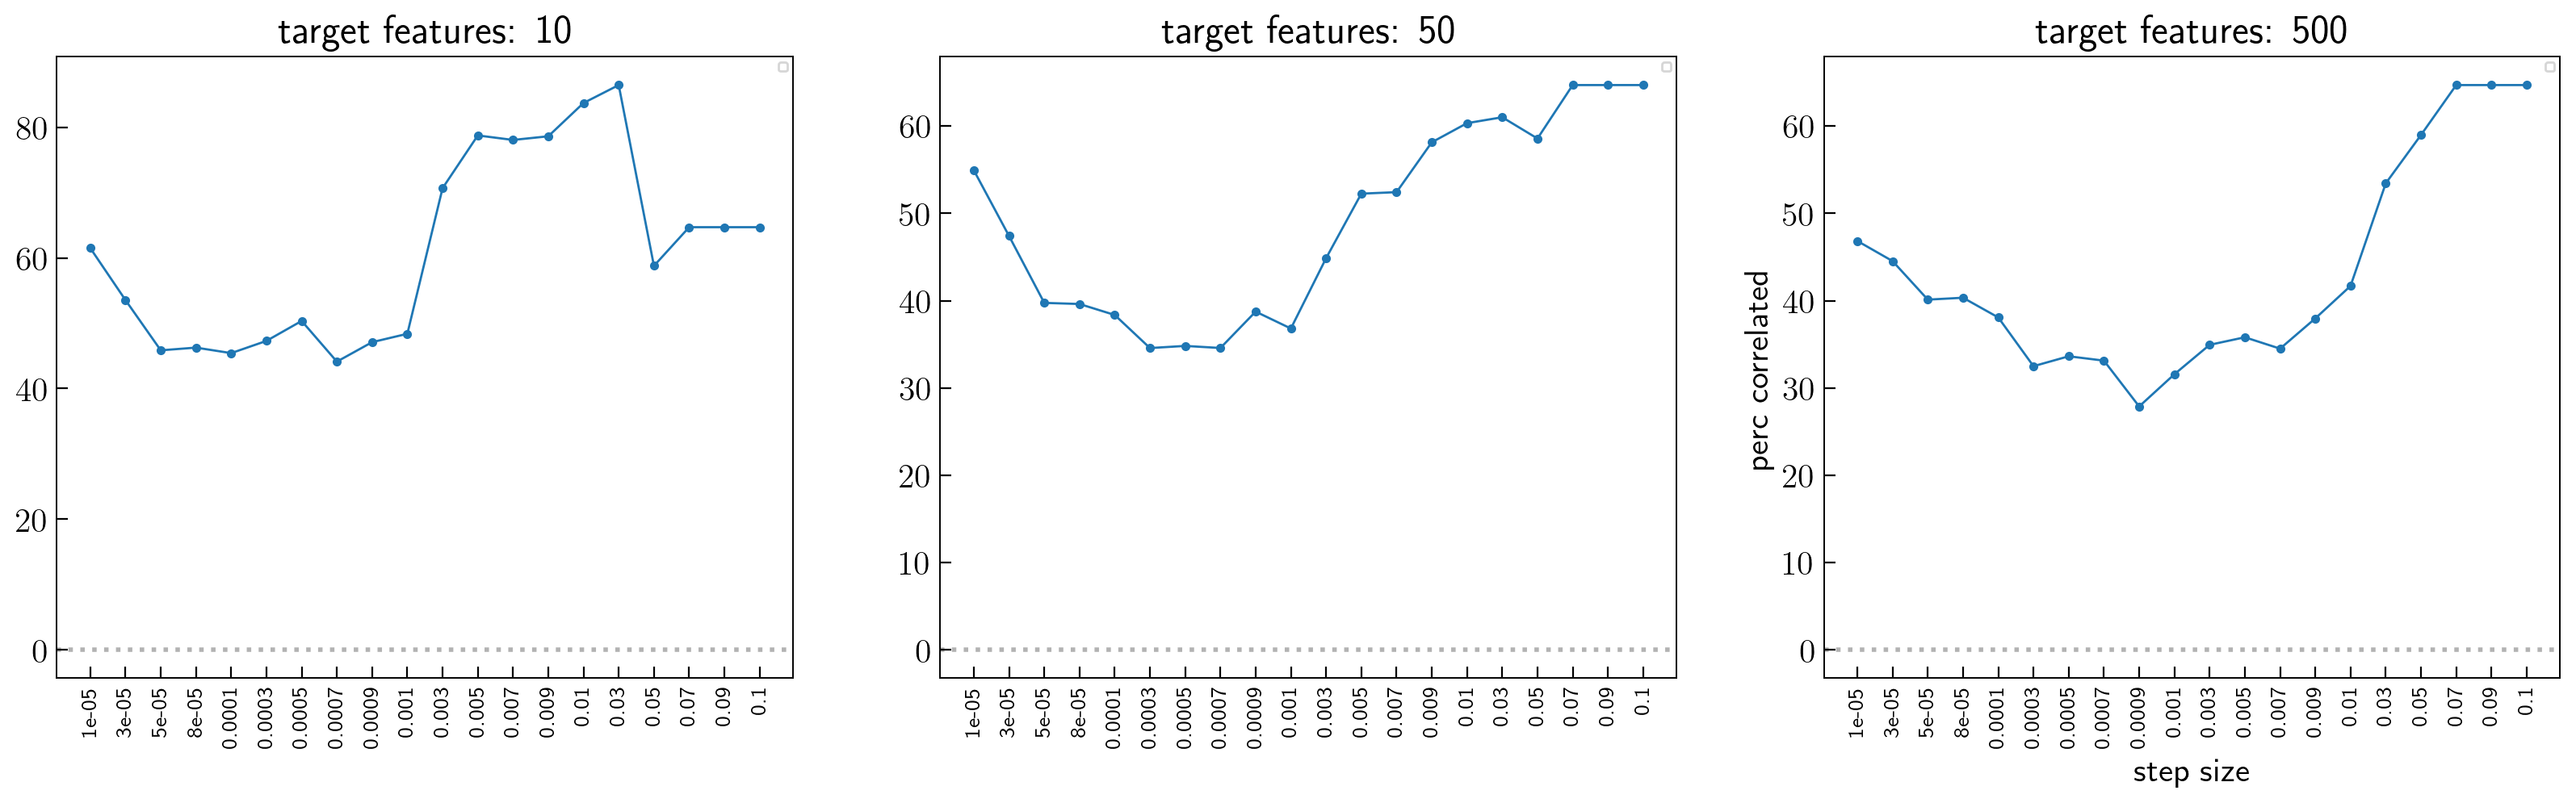

In [67]:
db=db1
total_runs_per_config = 10
markers = ['.',8,'s','p','*','h', 1,2,3,4]
marker_idx = 0
i = 0
j = 0

fig, axs = plt.subplots(1,3, figsize=(20,5), dpi=200)
plt.xlabel('step size')
plt.ylabel('perc correlated')
plt.xscale('linear')
plt.xticks(rotation=90)
plt.xticks(fontsize= 5)
#fig.axes[0].set_ylim(bottom=0.002, top=0.02)
#legend = plt.legend(prop={'size': 10})
#frame = legend.get_frame()
#frame.set_linewidth(0.6)
#frame.set_boxstyle('Square')
#print(f'{"params" :^15}{"features" :^8} {"std_cap" :^10} {"all_errors":^200} {"mean" :^10} {"total runs" :^10}')
for n_target_features in [10,50,500]:
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
    color_idx = 0
    mean_errors = []
    runs = pd.read_sql(f'select run, step_size from runs where n_target_features={n_target_features} and n2_decorrelate={0}', db.conn)
    p1 = np.unique(runs.values[:,1])
    for p in p1:
        p = [p]
        all_errors = []
        r = runs[(runs["step_size"] == p[0])]
        for run in r["run"].values:
            errors_list = pd.read_sql(f'select 100*(n_correlated/(n_mature+0.001)) from error_table where run={run} order by step desc limit 1', db.cerrors_listes
            all_errors.append(errors_list[0][0])
        all_errors = list(filter(lambda v: v==v, all_errors))
        if len(all_errors) >= total_runs_per_config:
            mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
        print(f'{str(p) :^30} {n_target_features :^20} {str(all_errors) :^200} {np.mean(all_errors) :^10.5f} {len(all_errors) :^10}')
    #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
    r["run"].values
    mean_errors = np.array(mean_errors)

    values = mean_errors
    axs[i].plot(values[:,0].astype('str'), values[:,1], label=f"", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
    #axs[j].set_ylim(bottom=0.002, top=0.02)
    axs[i].axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)
    axs[i].legend(prop={'size': 5})
    axs[i].set_title(f"target features: {n_target_features}")
    axs[i].set_xticks(values[:,0].astype(str))
    axs[i].set_xticklabels(values[:,0], rotation=90, fontsize=10)
    color_idx += 1
    i+=1
    print("\n")
    if j == 2:
        j=0
        i+=1
j+=1
i=0

plt.show()

# O(N2) Decorrelator + mag tester

           [1e-05]                      10                                                        [12.275197, 4.927192, 14.930367, 17.629875, 6.952197, 13.881785, 16.699915, 10.149835, 13.699892, 23.904182]                                                13.50504      10    
           [3e-05]                      10                                                         [8.125741, 5.730087, 12.117599, 12.253569, 7.023907, 10.494385, 15.971758, 7.640364, 10.632452, 17.422955]                                                 10.74128      10    
           [5e-05]                      10                                                          [7.423629, 3.459742, 9.609489, 12.943706, 6.06651, 10.522123, 14.799188, 7.769431, 8.658698, 14.312613]                                                   9.55651       10    
           [8e-05]                      10                                                            [6.395703, 2.354337, 10.3805, 12.326544, 5.677485, 9.78738, 11.02477, 6.9

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      10                                                                                                             []                                                                                                       nan         0     
            [0.07]                      10                                                                                                             []                                                                                                       nan         0     
            [0.09]                      10                                                                                                             []                                                                                                       nan         0     


            [0.1]                       10                                                                                                             []                                                                                                       nan         0     


           [1e-05]                      50                                                       [89.214005, 123.00795, 64.443764, 99.130737, 79.431877, 77.894409, 93.583908, 81.88166, 74.540077, 121.119087]                                               90.42475      10    
           [3e-05]                      50                                                       [63.263382, 90.401863, 60.544025, 81.676476, 59.339775, 57.268898, 88.882156, 71.202538, 74.801506, 82.879707]                                               73.02603      10    
           [5e-05]                      50                                                       [58.009552, 79.178261, 68.352585, 75.731209, 56.731712, 54.582554, 66.391487

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      50                                                                                                             []                                                                                                       nan         0     
            [0.07]                      50                                                                                                             []                                                                                                       nan         0     
            [0.09]                      50                                                                                                             []                                                                                                       nan         0     


            [0.1]                       50                                                                                                             []                                                                                                       nan         0     


           [1e-05]                     500                                                   [731.72998, 830.039185, 753.570557, 830.794006, 953.897583, 759.863953, 654.084412, 817.29248, 750.958679, 715.954651]                                          779.81855      10    
           [3e-05]                     500                                                  [782.082031, 669.858154, 788.686401, 650.429199, 873.219971, 586.658569, 585.672668, 728.801025, 657.739624, 685.316711]                                         700.84644      10    
           [5e-05]                     500                                                  [787.769348, 621.747009, 733.946899, 736.345886, 847.752991, 593.615417, 538.0565

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                     500                                                                                                             []                                                                                                       nan         0     
            [0.07]                     500                                                                                                             []                                                                                                       nan         0     
            [0.09]                     500                                                                                                             []                                                                                                       nan         0     


            [0.1]                      500                                                                                                             []                                                                                                       nan         0     




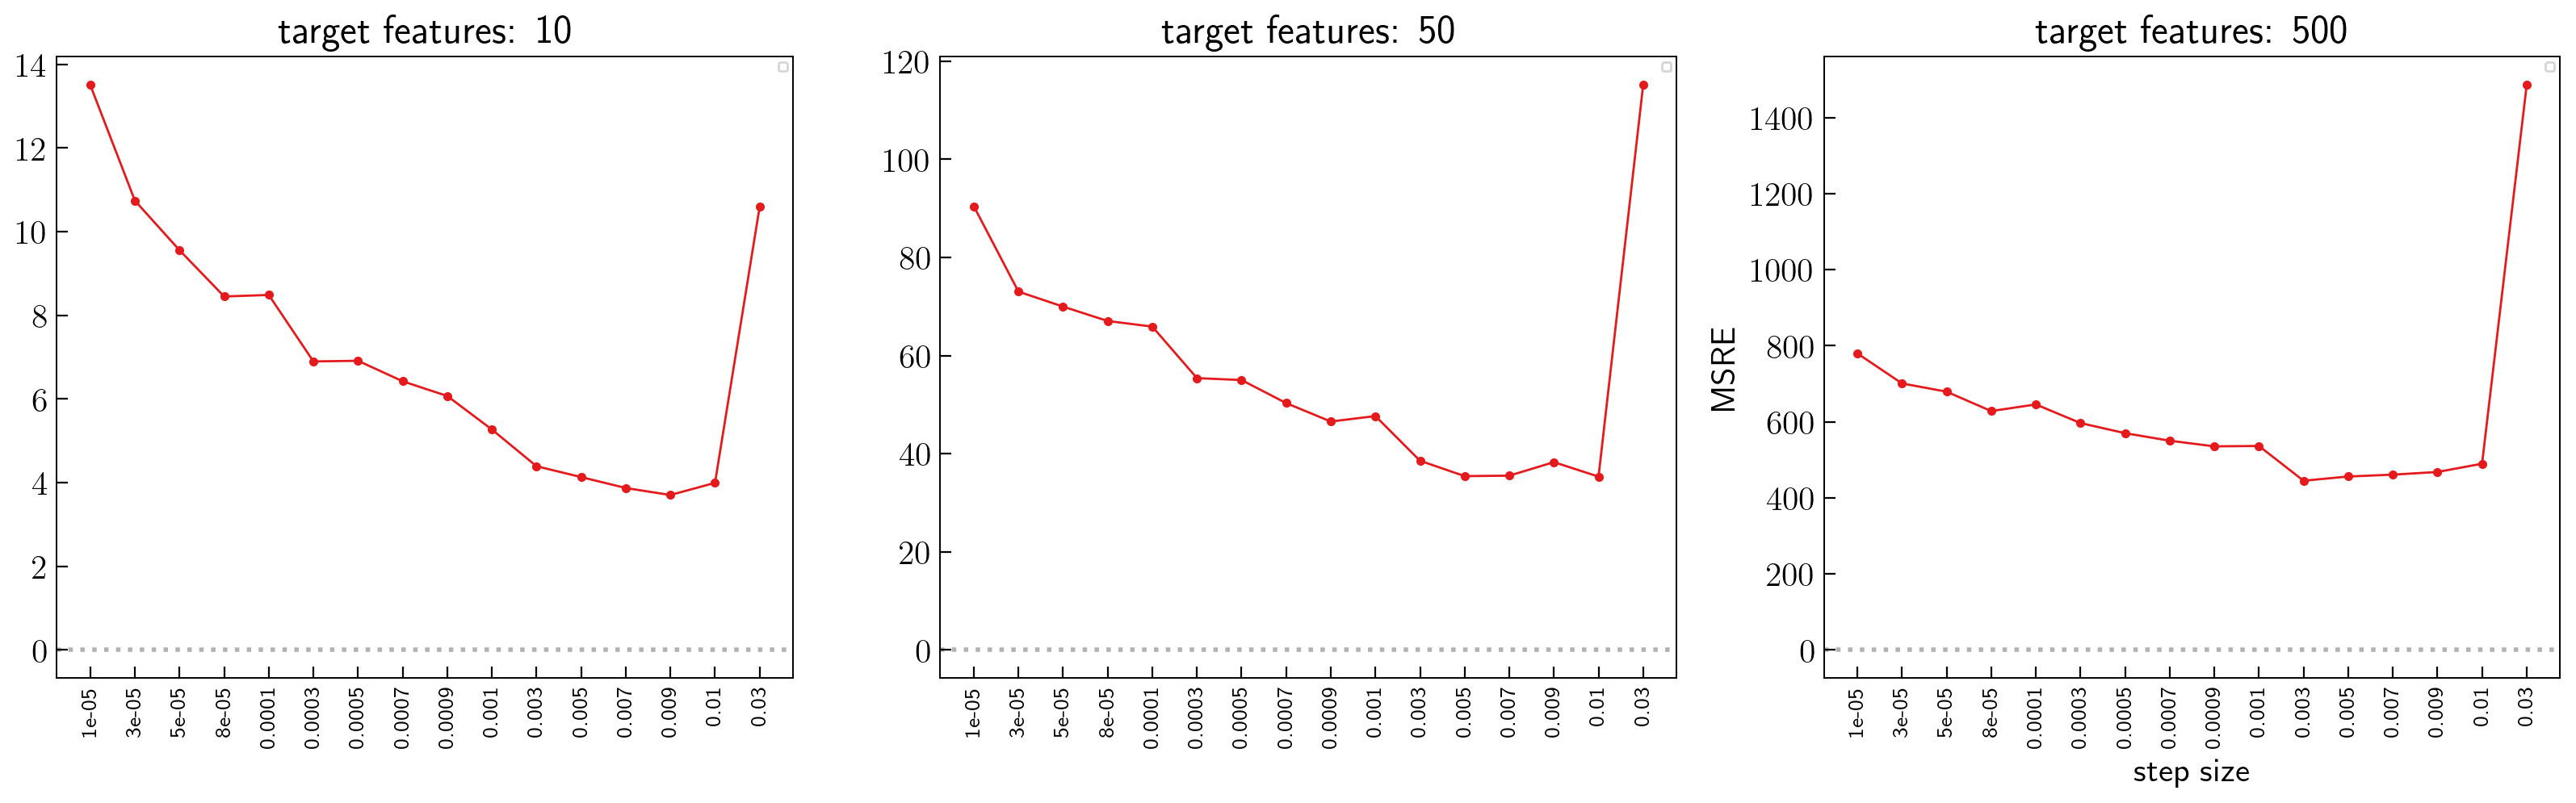

In [45]:
db=db1
total_runs_per_config = 10
markers = ['.',8,'s','p','*','h', 1,2,3,4]
marker_idx = 0
i = 0
j = 0

fig, axs = plt.subplots(1,3, figsize=(20,5), dpi=200)
plt.xlabel('step size')
plt.ylabel('MSRE')
plt.xscale('linear')
plt.xticks(rotation=90)
plt.xticks(fontsize= 5)
#fig.axes[0].set_ylim(bottom=0.002, top=0.02)
#legend = plt.legend(prop={'size': 10})
#frame = legend.get_frame()
#frame.set_linewidth(0.6)
#frame.set_boxstyle('Square')
#print(f'{"params" :^15}{"features" :^8} {"std_cap" :^10} {"all_errors":^200} {"mean" :^10} {"total runs" :^10}')
for n_target_features in [10,50,500]:
    colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']
    color_idx = 0
    mean_errors = []
    runs = pd.read_sql(f'select run, step_size from runs where n_target_features={n_target_features} and n2_decorrelate={1}', db.conn)
    p1 = np.unique(runs.values[:,1])
    for p in p1:
        p = [p]
        all_errors = []
        r = runs[(runs["step_size"] == p[0])]
        for run in r["run"].values:
            errors_list = pd.read_sql(f'select error from error_table where run={run}', db.conn).values
            if len(errors_list) >= 200:
                all_errors.append(errors_list[199][0])
        all_errors = list(filter(lambda v: v==v, all_errors))
        if len(all_errors) >= total_runs_per_config:
            mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
        print(f'{str(p) :^30} {n_target_features :^20} {str(all_errors) :^200} {np.mean(all_errors) :^10.5f} {len(all_errors) :^10}')
    #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
    r["run"].values
    mean_errors = np.array(mean_errors)

    values = mean_errors
    axs[i].plot(values[:,0].astype('str'), values[:,1], label=f"", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
    #axs[j].set_ylim(bottom=0.002, top=0.02)
    axs[i].axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)
    axs[i].legend(prop={'size': 5})
    axs[i].set_title(f"target features: {n_target_features}")
    axs[i].set_xticks(values[:,0].astype(str))
    axs[i].set_xticklabels(values[:,0], rotation=90, fontsize=10)
    color_idx += 1
    i+=1
    print("\n")
    if j == 2:
        j=0
        i+=1
j+=1
i=0

plt.show()

           [1e-05]                      10                                                                                  [0.8, 0.78, 0.78, 0.78, 0.78, 0.8, 0.78, 0.8, 0.74, 0.8]                                                                          0.78400       10    
           [3e-05]                      10                                                                                    [0.8, 0.8, 0.8, 0.8, 0.8, 0.78, 0.8, 0.78, 0.8, 0.8]                                                                            0.79600       10    
           [5e-05]                      10                                                                                    [0.8, 0.8, 0.8, 0.8, 0.78, 0.78, 0.8, 0.8, 0.8, 0.8]                                                                            0.79600       10    
           [8e-05]                      10                                                                                  [0.78, 0.78, 0.8, 0.78, 0.8, 0.78, 0.76, 0.8, 0.8, 

            [0.1]                       10                                                                                [0.96, 0.94, 0.92, 0.92, 0.92, 0.92, 0.94, 0.82, 0.88, 0.88]                                                                        0.91000       10    


           [1e-05]                      50                                                                                   [0.76, 0.8, 0.76, 0.78, 0.8, 0.78, 0.8, 0.8, 0.8, 0.8]                                                                           0.78800       10    
           [3e-05]                      50                                                                                   [0.8, 0.78, 0.8, 0.8, 0.78, 0.8, 0.76, 0.78, 0.8, 0.8]                                                                           0.79000       10    
           [5e-05]                      50                                                                                    [0.8, 0.8, 0.8, 0.8, 0.8, 0.78, 0.8, 0.8, 0.8, 

            [0.1]                       50                                                                                [0.96, 0.94, 0.92, 0.92, 0.92, 0.92, 0.94, 0.82, 0.88, 0.88]                                                                        0.91000       10    


           [1e-05]                     500                                                                                    [0.8, 0.8, 0.8, 0.78, 0.8, 0.78, 0.8, 0.8, 0.8, 0.8]                                                                            0.79600       10    
           [3e-05]                     500                                                                                    [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.78]                                                                             0.79800       10    
           [5e-05]                     500                                                                                   [0.8, 0.78, 0.8, 0.8, 0.76, 0.78, 0.8, 0.8, 0.8,

            [0.1]                      500                                                                                [0.96, 0.94, 0.92, 0.92, 0.92, 0.92, 0.94, 0.82, 0.88, 0.88]                                                                        0.91000       10    




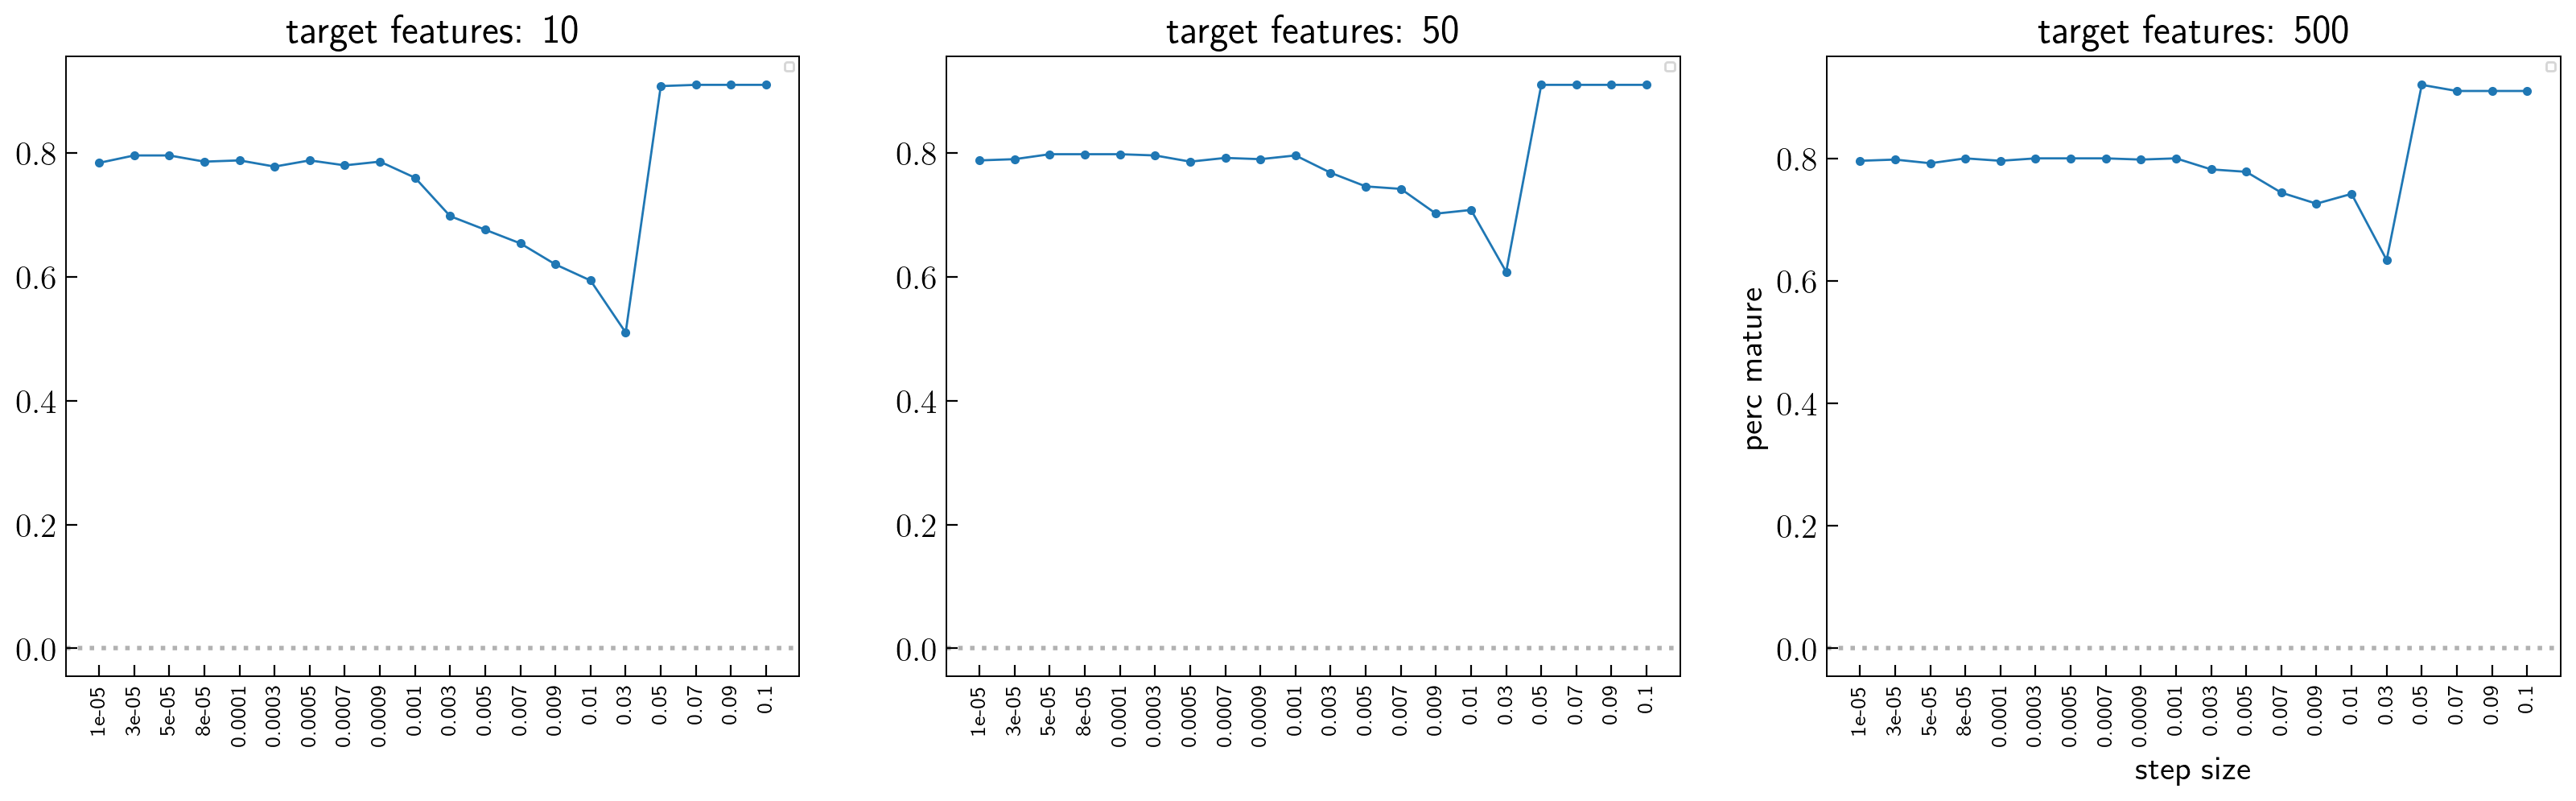

In [84]:
db=db1
total_runs_per_config = 10
markers = ['.',8,'s','p','*','h', 1,2,3,4]
marker_idx = 0
i = 0
j = 0

fig, axs = plt.subplots(1,3, figsize=(20,5), dpi=200)
plt.xlabel('step size')
plt.ylabel('perc mature')
plt.xscale('linear')
plt.xticks(rotation=90)
plt.xticks(fontsize= 5)
#fig.axes[0].set_ylim(bottom=0.002, top=0.02)
#legend = plt.legend(prop={'size': 10})
#frame = legend.get_frame()
#frame.set_linewidth(0.6)
#frame.set_boxstyle('Square')
#print(f'{"params" :^15}{"features" :^8} {"std_cap" :^10} {"all_errors":^200} {"mean" :^10} {"total runs" :^10}')
for n_target_features in [10,50,500]:
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
    color_idx = 0
    mean_errors = []
    runs = pd.read_sql(f'select run, step_size from runs where n_target_features={n_target_features} and n2_decorrelate={1}', db.conn)
    p1 = np.unique(runs.values[:,1])
    for p in p1:
        p = [p]
        all_errors = []
        r = runs[(runs["step_size"] == p[0])]
        for run in r["run"].values:
            errors_list = pd.read_sql(f'select n_mature/50 from error_table where run={run} order by step desc limit 1', db.conn).values
            all_errors.append(errors_list[0][0])
        all_errors = list(filter(lambda v: v==v, all_errors))
        if len(all_errors) >= total_runs_per_config:
            mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
        print(f'{str(p) :^30} {n_target_features :^20} {str(all_errors) :^200} {np.mean(all_errors) :^10.5f} {len(all_errors) :^10}')
    #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
    r["run"].values
    mean_errors = np.array(mean_errors)

    values = mean_errors
    axs[i].plot(values[:,0].astype('str'), values[:,1], label=f"", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
    #axs[j].set_ylim(bottom=0.002, top=0.02)
    axs[i].axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)
    axs[i].legend(prop={'size': 5})
    axs[i].set_title(f"target features: {n_target_features}")
    axs[i].set_xticks(values[:,0].astype(str))
    axs[i].set_xticklabels(values[:,0], rotation=90, fontsize=10)
    color_idx += 1
    i+=1
    print("\n")
    if j == 2:
        j=0
        i+=1
j+=1
i=0

plt.show()

           [1e-05]                      10                                                                                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.9999, 0.0, 0.0]                                                                            0.49999       10    
           [3e-05]                      10                                                                                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.2561, 0.0, 0.0]                                                                           1.02561       10    
           [5e-05]                      10                                                                                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                             0.00000       10    
           [8e-05]                      10                                                                                   [0.0, 0.0, 0.0, 0.0, 0.0, 7.6921, 0.0, 0.0, 0.0, 0

            [0.1]                       10                                                                                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                             0.00000       10    


           [1e-05]                      50                                                                                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                             0.00000       10    
           [3e-05]                      50                                                                                   [0.0, 5.1281, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                            0.51281       10    
           [5e-05]                      50                                                                                   [4.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

            [0.1]                       50                                                                                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                             0.00000       10    


           [1e-05]                     500                                                                                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                             0.00000       10    
           [3e-05]                     500                                                                                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                             0.00000       10    
           [5e-05]                     500                                                                                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

            [0.1]                      500                                                                                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                             0.00000       10    




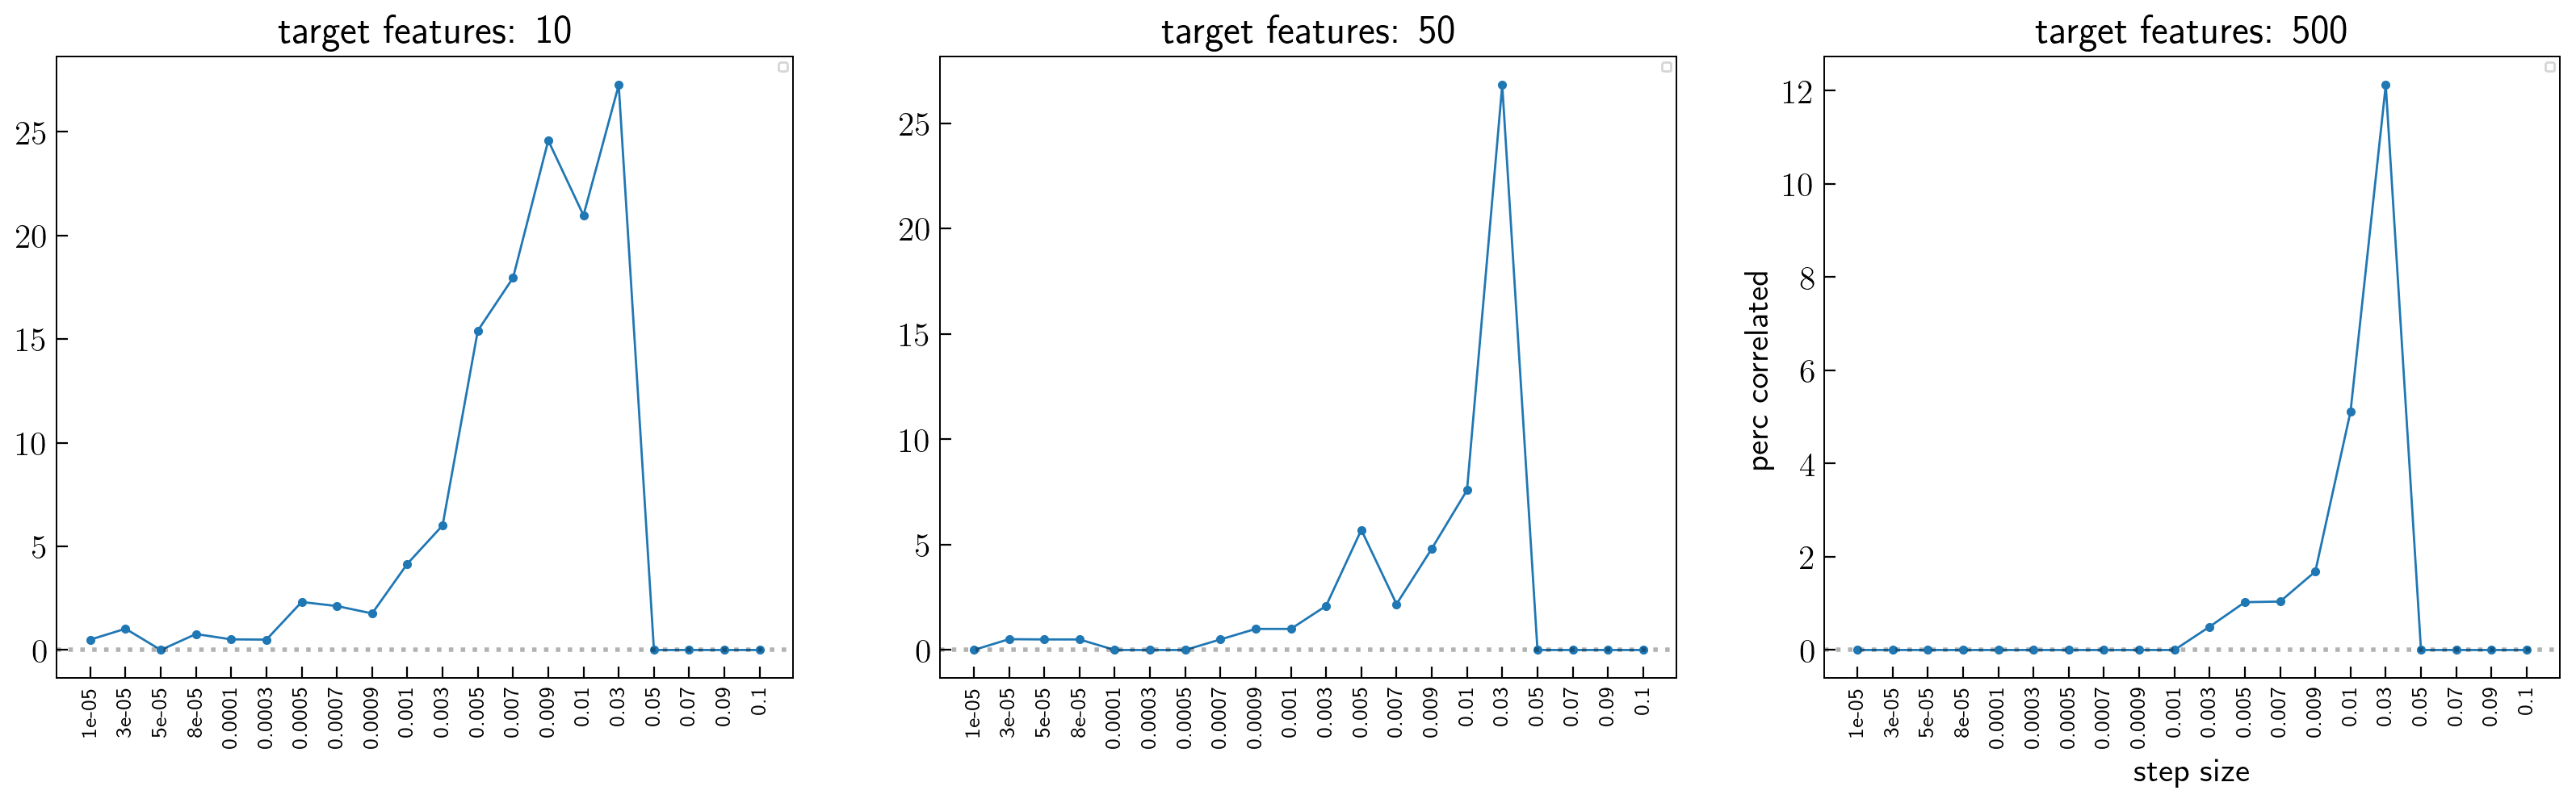

In [62]:
db=db1
total_runs_per_config = 10
markers = ['.',8,'s','p','*','h', 1,2,3,4]
marker_idx = 0
i = 0
j = 0

fig, axs = plt.subplots(1,3, figsize=(20,5), dpi=200)
plt.xlabel('step size')
plt.ylabel('perc correlated')
plt.xscale('linear')
plt.xticks(rotation=90)
plt.xticks(fontsize= 5)
#fig.axes[0].set_ylim(bottom=0.002, top=0.02)
#legend = plt.legend(prop={'size': 10})
#frame = legend.get_frame()
#frame.set_linewidth(0.6)
#frame.set_boxstyle('Square')
#print(f'{"params" :^15}{"features" :^8} {"std_cap" :^10} {"all_errors":^200} {"mean" :^10} {"total runs" :^10}')
for n_target_features in [10,50,500]:
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
    color_idx = 0
    mean_errors = []
    runs = pd.read_sql(f'select run, step_size from runs where n_target_features={n_target_features} and n2_decorrelate={1}', db.conn)
    p1 = np.unique(runs.values[:,1])
    for p in p1:
        p = [p]
        all_errors = []
        r = runs[(runs["step_size"] == p[0])]
        for run in r["run"].values:
            errors_list = pd.read_sql(f'select 100*(n_correlated/(n_mature+0.001)) from error_table where run={run} order by step desc limit 1', db.conn).values
            all_errors.append(errors_list[0][0])
        all_errors = list(filter(lambda v: v==v, all_errors))
        if len(all_errors) >= total_runs_per_config:
            mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
        print(f'{str(p) :^30} {n_target_features :^20} {str(all_errors) :^200} {np.mean(all_errors) :^10.5f} {len(all_errors) :^10}')
    #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
    r["run"].values
    mean_errors = np.array(mean_errors)

    values = mean_errors
    axs[i].plot(values[:,0].astype('str'), values[:,1], label=f"", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
    #axs[j].set_ylim(bottom=0.002, top=0.02)
    axs[i].axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)
    axs[i].legend(prop={'size': 5})
    axs[i].set_title(f"target features: {n_target_features}")
    axs[i].set_xticks(values[:,0].astype(str))
    axs[i].set_xticklabels(values[:,0], rotation=90, fontsize=10)
    color_idx += 1
    i+=1
    print("\n")
    if j == 2:
        j=0
        i+=1
j+=1
i=0

plt.show()

# Random Decorrelator + Mag tester

           [1e-05]                      10                                                         [8.225625, 6.399018, 13.224712, 18.422363, 8.172049, 13.250534, 18.973972, 12.588853, 14.22697, 32.256756]                                                 14.57409      10    
           [3e-05]                      10                                                         [8.819886, 3.832507, 12.110754, 10.931003, 5.873437, 12.371433, 12.595322, 5.402241, 11.538051, 17.536348]                                                 10.10110      10    
           [5e-05]                      10                                                          [9.220664, 3.699754, 13.812784, 11.288384, 5.66275, 7.514109, 15.148907, 5.199135, 13.602514, 18.548939]                                                  10.36979      10    
           [8e-05]                      10                                                          [6.915182, 3.238124, 10.690064, 10.967546, 5.793539, 5.694665, 13.482464, 7

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      10                                                                                                             []                                                                                                       nan         0     
            [0.07]                      10                                                                                                             []                                                                                                       nan         0     
            [0.09]                      10                                                                                                             []                                                                                                       nan         0     
            [0.1]                       10                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      10                                                                                                             []                                                                                                       nan         0     
            [0.07]                      10                                                                                                             []                                                                                                       nan         0     
            [0.09]                      10                                                                                                             []                                                                                                       nan         0     
            [0.1]                       10                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      10                                                                                                             []                                                                                                       nan         0     
            [0.07]                      10                                                                                                             []                                                                                                       nan         0     
            [0.09]                      10                                                                                                             []                                                                                                       nan         0     
            [0.1]                       10                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      10                                                                                                             []                                                                                                       nan         0     
            [0.07]                      10                                                                                                             []                                                                                                       nan         0     
            [0.09]                      10                                                                                                             []                                                                                                       nan         0     
            [0.1]                       10                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      50                                                                                                             []                                                                                                       nan         0     
            [0.07]                      50                                                                                                             []                                                                                                       nan         0     
            [0.09]                      50                                                                                                             []                                                                                                       nan         0     
            [0.1]                       50                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      50                                                                                                             []                                                                                                       nan         0     
            [0.07]                      50                                                                                                             []                                                                                                       nan         0     
            [0.09]                      50                                                                                                             []                                                                                                       nan         0     
            [0.1]                       50                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      50                                                                                                             []                                                                                                       nan         0     
            [0.07]                      50                                                                                                             []                                                                                                       nan         0     
            [0.09]                      50                                                                                                             []                                                                                                       nan         0     
            [0.1]                       50                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      50                                                                                                             []                                                                                                       nan         0     
            [0.07]                      50                                                                                                             []                                                                                                       nan         0     
            [0.09]                      50                                                                                                             []                                                                                                       nan         0     
            [0.1]                       50                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                     500                                                                                                             []                                                                                                       nan         0     
            [0.07]                     500                                                                                                             []                                                                                                       nan         0     
            [0.09]                     500                                                                                                             []                                                                                                       nan         0     
            [0.1]                      500                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                     500                                                                                                             []                                                                                                       nan         0     
            [0.07]                     500                                                                                                             []                                                                                                       nan         0     
            [0.09]                     500                                                                                                             []                                                                                                       nan         0     
            [0.1]                      500                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                     500                                                                                                             []                                                                                                       nan         0     
            [0.07]                     500                                                                                                             []                                                                                                       nan         0     
            [0.09]                     500                                                                                                             []                                                                                                       nan         0     
            [0.1]                      500                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                     500                                                                                                             []                                                                                                       nan         0     
            [0.07]                     500                                                                                                             []                                                                                                       nan         0     
            [0.09]                     500                                                                                                             []                                                                                                       nan         0     
            [0.1]                      500                                                                                                             []                      

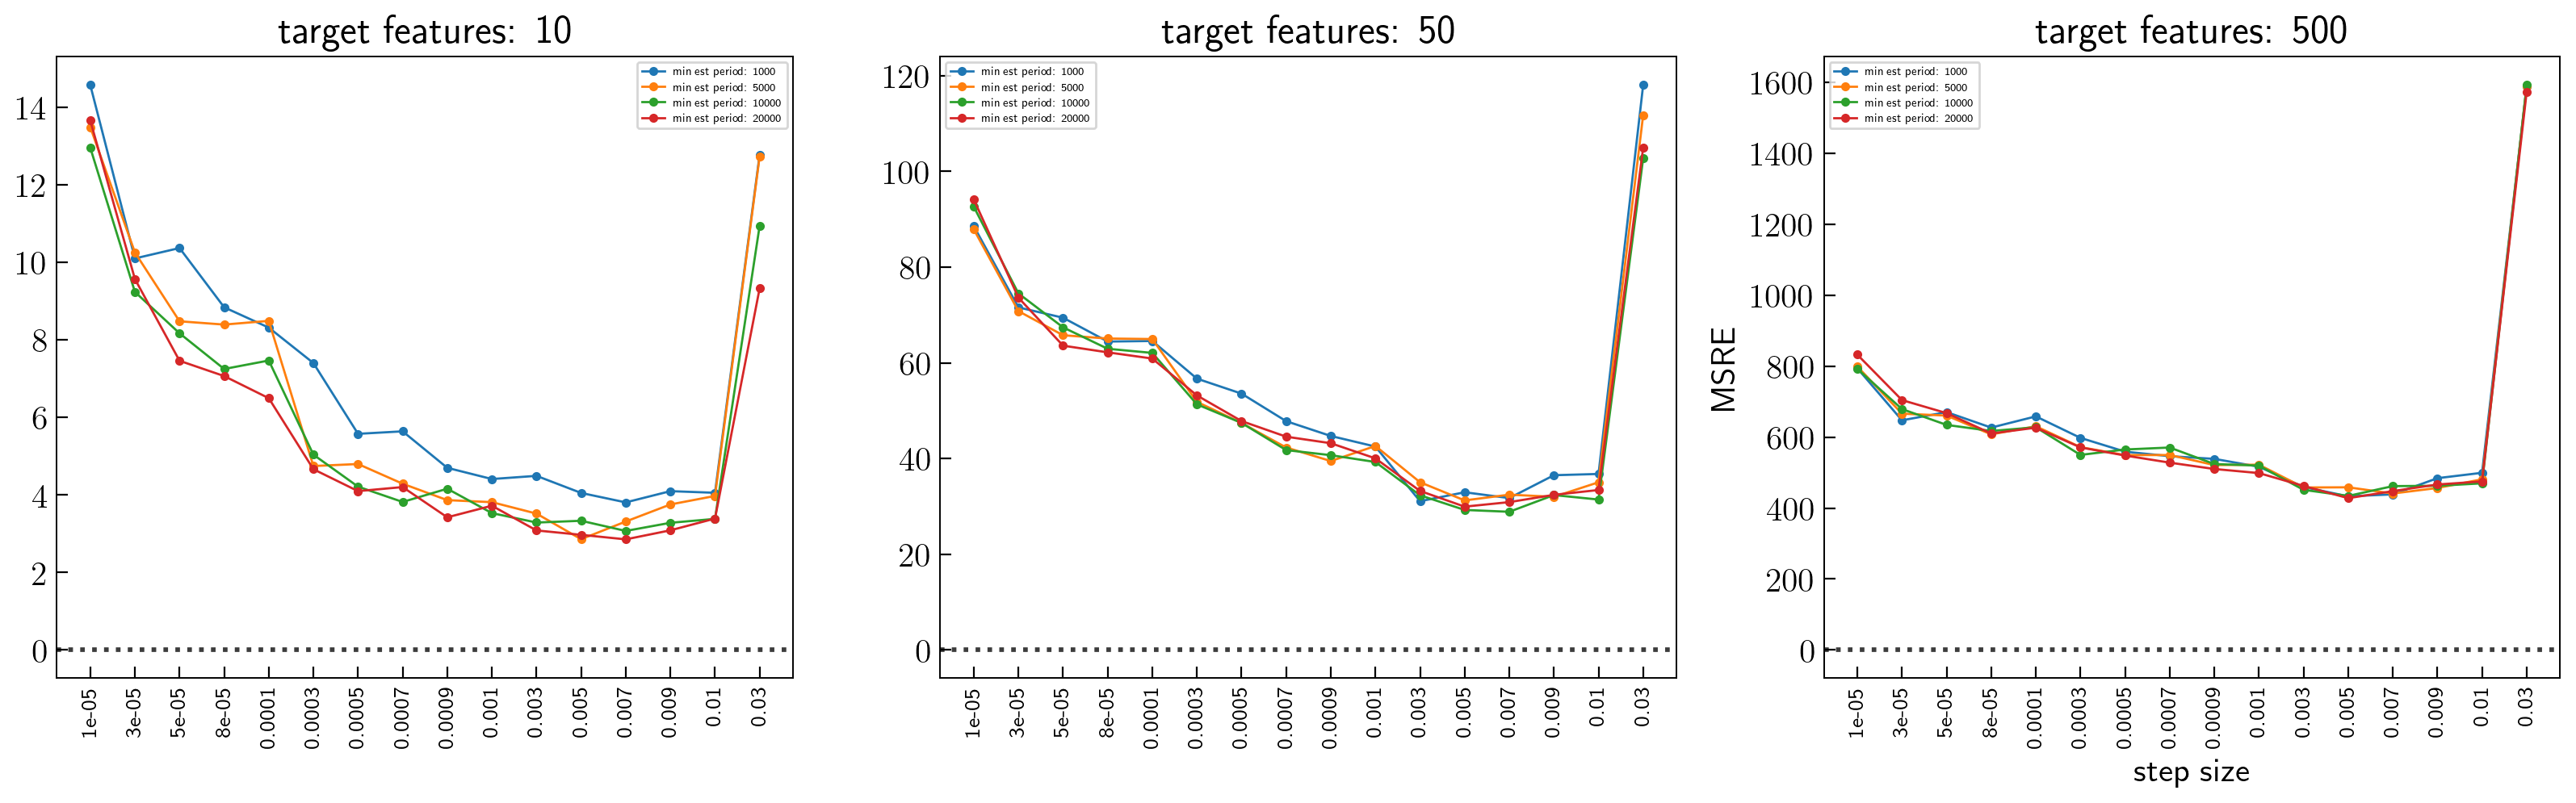

In [14]:
db=db2
total_runs_per_config = 10
markers = ['.',8,'s','p','*','h', 1,2,3,4]
marker_idx = 0
i = 0
j = 0

fig, axs = plt.subplots(1,3, figsize=(20,5), dpi=200)
plt.xlabel('step size')
plt.ylabel('MSRE')
plt.xscale('linear')
plt.xticks(rotation=90)
plt.xticks(fontsize= 5)
#fig.axes[0].set_ylim(bottom=0.002, top=0.02)
#legend = plt.legend(prop={'size': 10})
#frame = legend.get_frame()
#frame.set_linewidth(0.6)
#frame.set_boxstyle('Square')
#print(f'{"params" :^15}{"features" :^8} {"std_cap" :^10} {"all_errors":^200} {"mean" :^10} {"total runs" :^10}')
for n_target_features in [10,50,500]:
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
    color_idx = 0
    for min_estimation_period in [1000, 5000, 10000, 20000]:

        mean_errors = []
        runs = pd.read_sql(f'select run, step_size from runs where n_target_features={n_target_features} and random_decorrelate={1} and min_estimation_period={min_estimation_period}', db.conn)
        p1 = np.unique(runs.values[:,1])
        for p in p1:
            p = [p]
            all_errors = []
            r = runs[(runs["step_size"] == p[0])]
            for run in r["run"].values:
                errors_list = pd.read_sql(f'select error from error_table where run={run}', db.conn).values
                if len(errors_list) >= 200:
                    all_errors.append(errors_list[199][0])
            all_errors = list(filter(lambda v: v==v, all_errors))
            if len(all_errors) >= total_runs_per_config:
                mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
            print(f'{str(p) :^30} {n_target_features :^20} {str(all_errors) :^200} {np.mean(all_errors) :^10.5f} {len(all_errors) :^10}')
        #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
        r["run"].values
        mean_errors = np.array(mean_errors)

        values = mean_errors
        axs[i].plot(values[:,0].astype('str'), values[:,1], label=f"min est period: {min_estimation_period}", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
        #axs[j].set_ylim(bottom=0.002, top=0.02)
        axs[i].axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)
        axs[i].legend(prop={'size': 5})
        axs[i].set_title(f"target features: {n_target_features}")
        axs[i].set_xticks(values[:,0].astype(str))
        axs[i].set_xticklabels(values[:,0], rotation=90, fontsize=10)
        color_idx += 1
    i+=1
    print("\n")
j+=1
i=0

plt.show()

           [1e-05]                      10                                                                                 [0.8, 0.78, 0.78, 0.78, 0.78, 0.78, 0.76, 0.78, 0.78, 0.8]                                                                         0.78200       10    
           [3e-05]                      10                                                                                  [0.8, 0.8, 0.78, 0.8, 0.8, 0.8, 0.78, 0.78, 0.76, 0.78]                                                                           0.78800       10    
           [5e-05]                      10                                                                                   [0.76, 0.78, 0.78, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]                                                                            0.79200       10    
           [8e-05]                      10                                                                                   [0.8, 0.8, 0.8, 0.8, 0.8, 0.74, 0.74, 0.76, 0.8, 0

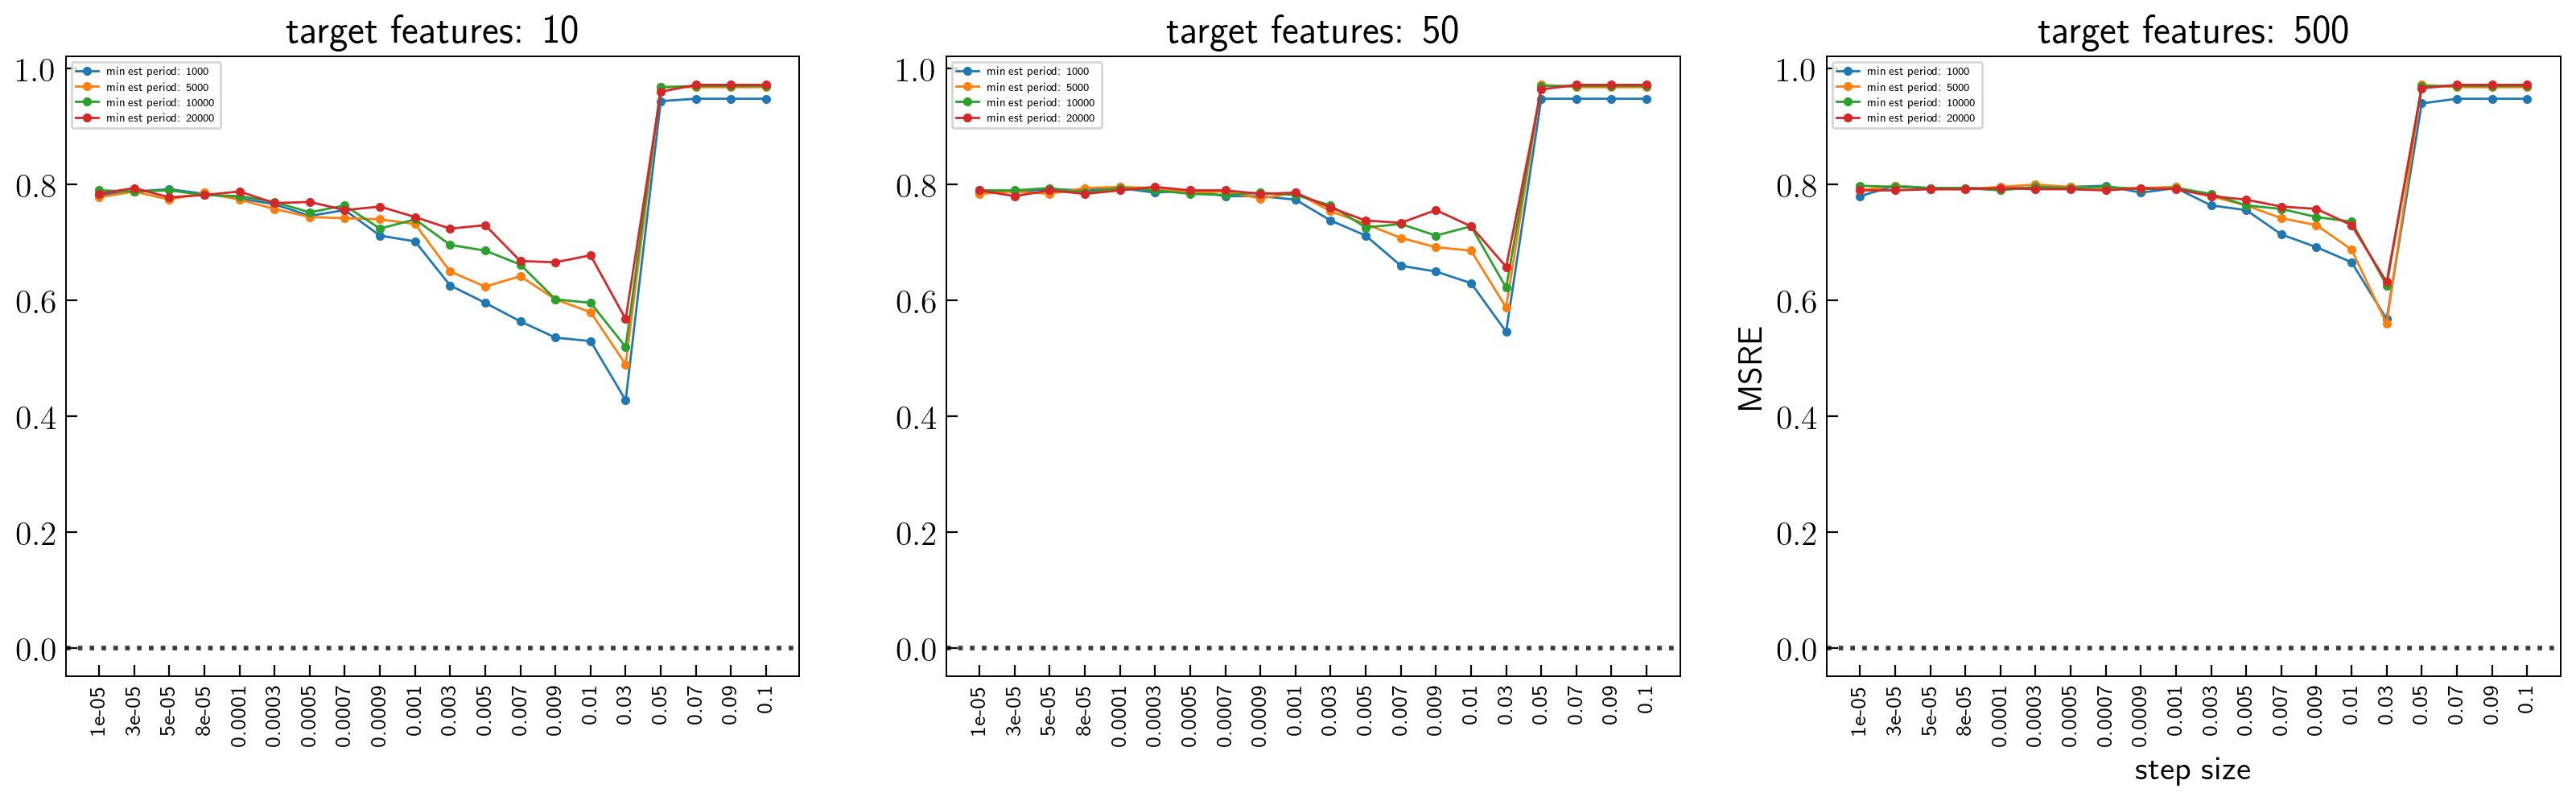

In [15]:
db=db2
total_runs_per_config = 10
markers = ['.',8,'s','p','*','h', 1,2,3,4]
marker_idx = 0
i = 0
j = 0

fig, axs = plt.subplots(1,3, figsize=(20,5), dpi=200)
plt.xlabel('step size')
plt.ylabel('MSRE')
plt.xscale('linear')
plt.xticks(rotation=90)
plt.xticks(fontsize= 5)
#fig.axes[0].set_ylim(bottom=0.002, top=0.02)
#legend = plt.legend(prop={'size': 10})
#frame = legend.get_frame()
#frame.set_linewidth(0.6)
#frame.set_boxstyle('Square')
#print(f'{"params" :^15}{"features" :^8} {"std_cap" :^10} {"all_errors":^200} {"mean" :^10} {"total runs" :^10}')
for n_target_features in [10,50,500]:
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
    color_idx = 0
    for min_estimation_period in [1000, 5000, 10000, 20000]:

        mean_errors = []
        runs = pd.read_sql(f'select run, step_size from runs where n_target_features={n_target_features} and random_decorrelate={1} and min_estimation_period={min_estimation_period}', db.conn)
        p1 = np.unique(runs.values[:,1])
        for p in p1:
            p = [p]
            all_errors = []
            r = runs[(runs["step_size"] == p[0])]
            for run in r["run"].values:
                errors_list = pd.read_sql(f'select n_mature/50 from error_table where run={run} order by step desc limit 1', db.conn).values
                all_errors.append(errors_list[0][0])
            all_errors = list(filter(lambda v: v==v, all_errors))
            if len(all_errors) >= total_runs_per_config:
                mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
            print(f'{str(p) :^30} {n_target_features :^20} {str(all_errors) :^200} {np.mean(all_errors) :^10.5f} {len(all_errors) :^10}')
        #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
        r["run"].values
        mean_errors = np.array(mean_errors)

        values = mean_errors
        axs[i].plot(values[:,0].astype('str'), values[:,1], label=f"min est period: {min_estimation_period}", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
        #axs[j].set_ylim(bottom=0.002, top=0.02)
        axs[i].axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)
        axs[i].legend(prop={'size': 5})
        axs[i].set_title(f"target features: {n_target_features}")
        axs[i].set_xticks(values[:,0].astype(str))
        axs[i].set_xticklabels(values[:,0], rotation=90, fontsize=10)
        color_idx += 1
    i+=1
    print("\n")
j+=1
i=0

plt.show()

           [1e-05]                      10                                                                                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.263, 0.0, 0.0, 0.0]                                                                            0.52630       10    
           [3e-05]                      10                                                                                  [0.0, 0.0, 0.0, 0.0, 0.0, 4.9999, 0.0, 5.1281, 0.0, 0.0]                                                                          1.01280       10    
           [5e-05]                      10                                                                                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.9999, 0.0, 0.0]                                                                            0.49999       10    
           [8e-05]                      10                                                                                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.1079, 0.0, 0.0, 0

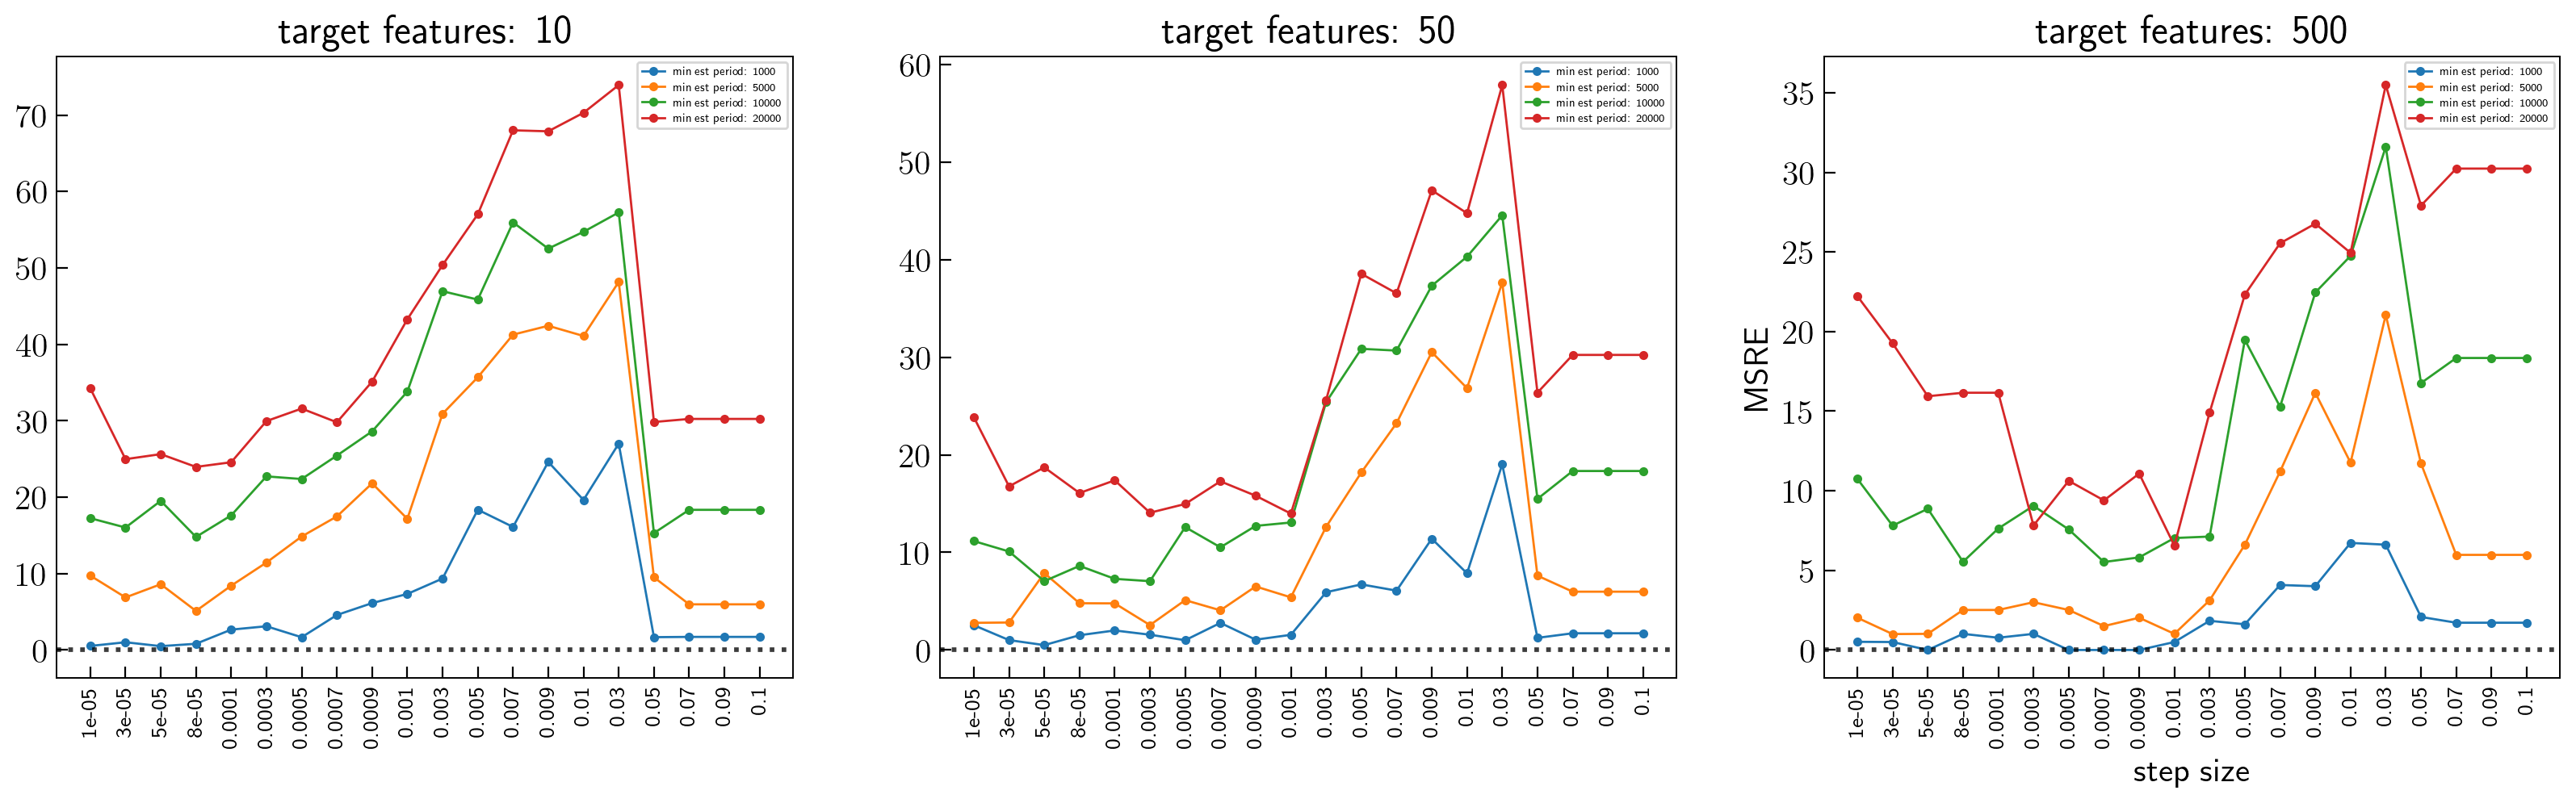

In [16]:
db=db2
total_runs_per_config = 10
markers = ['.',8,'s','p','*','h', 1,2,3,4]
marker_idx = 0
i = 0
j = 0

fig, axs = plt.subplots(1,3, figsize=(20,5), dpi=200)
plt.xlabel('step size')
plt.ylabel('MSRE')
plt.xscale('linear')
plt.xticks(rotation=90)
plt.xticks(fontsize= 5)
#fig.axes[0].set_ylim(bottom=0.002, top=0.02)
#legend = plt.legend(prop={'size': 10})
#frame = legend.get_frame()
#frame.set_linewidth(0.6)
#frame.set_boxstyle('Square')
#print(f'{"params" :^15}{"features" :^8} {"std_cap" :^10} {"all_errors":^200} {"mean" :^10} {"total runs" :^10}')
for n_target_features in [10,50,500]:
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
    color_idx = 0
    for min_estimation_period in [1000, 5000, 10000, 20000]:

        mean_errors = []
        runs = pd.read_sql(f'select run, step_size from runs where n_target_features={n_target_features} and random_decorrelate={1} and min_estimation_period={min_estimation_period}', db.conn)
        p1 = np.unique(runs.values[:,1])
        for p in p1:
            p = [p]
            all_errors = []
            r = runs[(runs["step_size"] == p[0])]
            for run in r["run"].values:
                errors_list = pd.read_sql(f'select 100*(n_correlated/(n_mature+0.001)) from error_table where run={run} order by step desc limit 1', db.conn).values
                all_errors.append(errors_list[0][0])
            all_errors = list(filter(lambda v: v==v, all_errors))
            if len(all_errors) >= total_runs_per_config:
                mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
            print(f'{str(p) :^30} {n_target_features :^20} {str(all_errors) :^200} {np.mean(all_errors) :^10.5f} {len(all_errors) :^10}')
        #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
        r["run"].values
        mean_errors = np.array(mean_errors)

        values = mean_errors
        axs[i].plot(values[:,0].astype('str'), values[:,1], label=f"min est period: {min_estimation_period}", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
        #axs[j].set_ylim(bottom=0.002, top=0.02)
        axs[i].axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)
        axs[i].legend(prop={'size': 5})
        axs[i].set_title(f"target features: {n_target_features}")
        axs[i].set_xticks(values[:,0].astype(str))
        axs[i].set_xticklabels(values[:,0], rotation=90, fontsize=10)
        color_idx += 1
    i+=1
    print("\n")
j+=1
i=0

plt.show()

# Random Thresh Decorrelator + Mag tester

           [1e-05]                      10                                                         [9.721336, 5.59484, 11.591829, 19.188374, 7.575046, 10.091876, 21.532915, 12.747032, 15.96128, 25.220907]                                                  13.92254      10    
           [3e-05]                      10                                                         [7.945578, 3.933348, 14.085093, 14.428246, 7.274909, 10.153336, 16.823776, 11.402348, 12.23354, 15.492089]                                                 11.37723      10    
           [5e-05]                      10                                                          [7.675143, 4.104109, 13.761389, 14.235848, 5.540994, 11.534143, 17.512562, 7.705491, 9.501308, 17.1022]                                                   10.86732      10    
           [8e-05]                      10                                                          [6.542386, 2.727016, 10.825104, 16.540012, 6.292188, 7.574545, 11.2601, 10.

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      10                                                                                                             []                                                                                                       nan         0     
            [0.07]                      10                                                                                                             []                                                                                                       nan         0     
            [0.09]                      10                                                                                                             []                                                                                                       nan         0     
            [0.1]                       10                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      10                                                                                                             []                                                                                                       nan         0     
            [0.07]                      10                                                                                                             []                                                                                                       nan         0     
            [0.09]                      10                                                                                                             []                                                                                                       nan         0     
            [0.1]                       10                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      10                                                                                                             []                                                                                                       nan         0     
            [0.07]                      10                                                                                                             []                                                                                                       nan         0     
            [0.09]                      10                                                                                                             []                                                                                                       nan         0     
            [0.1]                       10                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      10                                                                                                             []                                                                                                       nan         0     
            [0.07]                      10                                                                                                             []                                                                                                       nan         0     
            [0.09]                      10                                                                                                             []                                                                                                       nan         0     
            [0.1]                       10                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      50                                                                                                             []                                                                                                       nan         0     
            [0.07]                      50                                                                                                             []                                                                                                       nan         0     
            [0.09]                      50                                                                                                             []                                                                                                       nan         0     
            [0.1]                       50                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      50                                                                                                             []                                                                                                       nan         0     
            [0.07]                      50                                                                                                             []                                                                                                       nan         0     
            [0.09]                      50                                                                                                             []                                                                                                       nan         0     
            [0.1]                       50                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      50                                                                                                             []                                                                                                       nan         0     
            [0.07]                      50                                                                                                             []                                                                                                       nan         0     
            [0.09]                      50                                                                                                             []                                                                                                       nan         0     
            [0.1]                       50                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                      50                                                                                                             []                                                                                                       nan         0     
            [0.07]                      50                                                                                                             []                                                                                                       nan         0     
            [0.09]                      50                                                                                                             []                                                                                                       nan         0     
            [0.1]                       50                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                     500                                                                                                             []                                                                                                       nan         0     
            [0.07]                     500                                                                                                             []                                                                                                       nan         0     
            [0.09]                     500                                                                                                             []                                                                                                       nan         0     
            [0.1]                      500                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                     500                                                                                                             []                                                                                                       nan         0     
            [0.07]                     500                                                                                                             []                                                                                                       nan         0     
            [0.09]                     500                                                                                                             []                                                                                                       nan         0     
            [0.1]                      500                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                     500                                                                                                             []                                                                                                       nan         0     
            [0.07]                     500                                                                                                             []                                                                                                       nan         0     
            [0.09]                     500                                                                                                             []                                                                                                       nan         0     
            [0.1]                      500                                                                                                             []                      

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


            [0.05]                     500                                                                                                             []                                                                                                       nan         0     
            [0.07]                     500                                                                                                             []                                                                                                       nan         0     
            [0.09]                     500                                                                                                             []                                                                                                       nan         0     
            [0.1]                      500                                                                                                             []                      

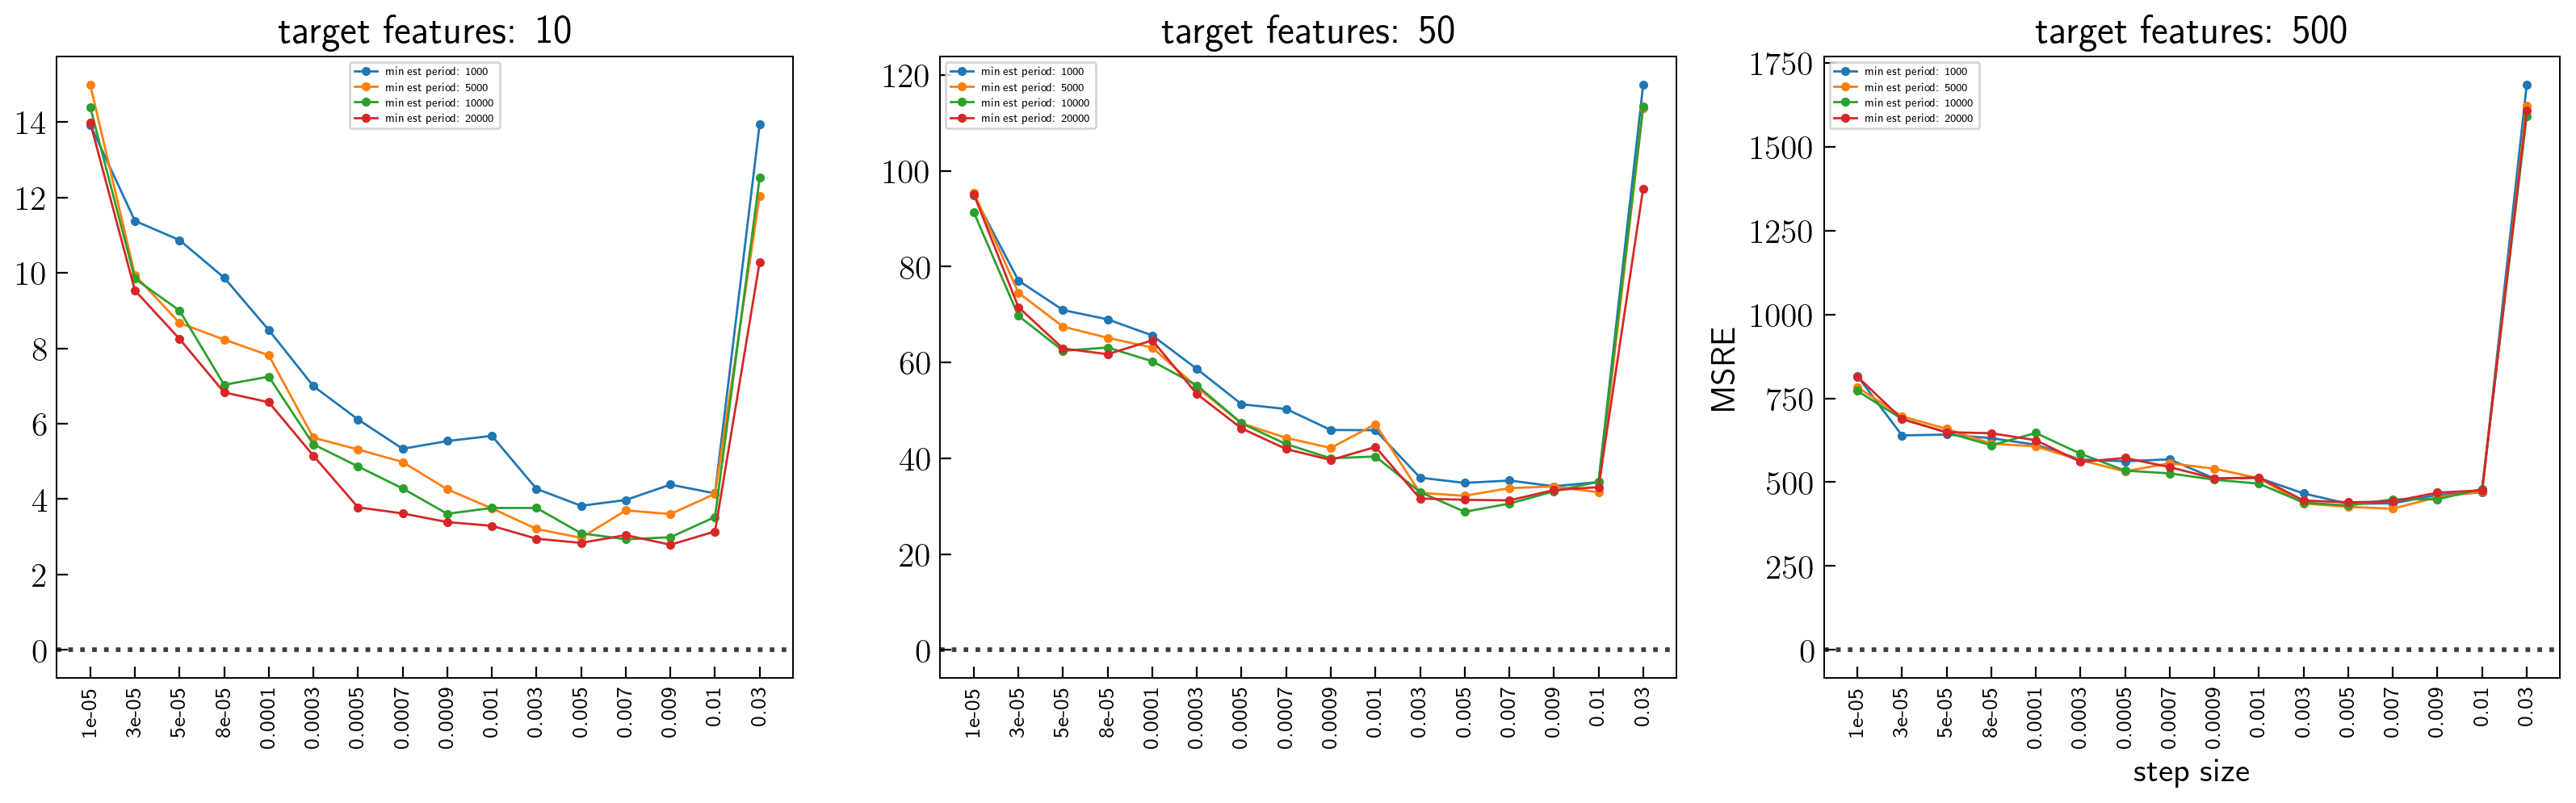

In [18]:
db=db3
total_runs_per_config = 10
markers = ['.',8,'s','p','*','h', 1,2,3,4]
marker_idx = 0
i = 0
j = 0

fig, axs = plt.subplots(1,3, figsize=(20,5), dpi=200)
plt.xlabel('step size')
plt.ylabel('MSRE')
plt.xscale('linear')
plt.xticks(rotation=90)
plt.xticks(fontsize= 5)
#fig.axes[0].set_ylim(bottom=0.002, top=0.02)
#legend = plt.legend(prop={'size': 10})
#frame = legend.get_frame()
#frame.set_linewidth(0.6)
#frame.set_boxstyle('Square')
#print(f'{"params" :^15}{"features" :^8} {"std_cap" :^10} {"all_errors":^200} {"mean" :^10} {"total runs" :^10}')
for n_target_features in [10,50,500]:
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
    color_idx = 0
    for min_estimation_period in [1000, 5000, 10000, 20000]:

        mean_errors = []
        runs = pd.read_sql(f'select run, step_size from runs where n_target_features={n_target_features} and random_thresh_decorrelate={1} and min_estimation_period={min_estimation_period}', db.conn)
        p1 = np.unique(runs.values[:,1])
        for p in p1:
            p = [p]
            all_errors = []
            r = runs[(runs["step_size"] == p[0])]
            for run in r["run"].values:
                errors_list = pd.read_sql(f'select error from error_table where run={run}', db.conn).values
                if len(errors_list) >= 200:
                    all_errors.append(errors_list[199][0])
            all_errors = list(filter(lambda v: v==v, all_errors))
            if len(all_errors) >= total_runs_per_config:
                mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
            print(f'{str(p) :^30} {n_target_features :^20} {str(all_errors) :^200} {np.mean(all_errors) :^10.5f} {len(all_errors) :^10}')
        #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
        r["run"].values
        mean_errors = np.array(mean_errors)

        values = mean_errors
        axs[i].plot(values[:,0].astype('str'), values[:,1], label=f"min est period: {min_estimation_period}", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
        #axs[j].set_ylim(bottom=0.002, top=0.02)
        axs[i].axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)
        axs[i].legend(prop={'size': 5})
        axs[i].set_title(f"target features: {n_target_features}")
        axs[i].set_xticks(values[:,0].astype(str))
        axs[i].set_xticklabels(values[:,0], rotation=90, fontsize=10)
        color_idx += 1
    i+=1
    print("\n")
j+=1
i=0

plt.show()

           [1e-05]                      10                                                                                  [0.74, 0.78, 0.8, 0.8, 0.78, 0.8, 0.72, 0.76, 0.78, 0.8]                                                                          0.77600       10    
           [3e-05]                      10                                                                                  [0.8, 0.76, 0.8, 0.78, 0.8, 0.8, 0.78, 0.8, 0.78, 0.76]                                                                           0.78600       10    
           [5e-05]                      10                                                                                 [0.78, 0.78, 0.8, 0.78, 0.8, 0.8, 0.78, 0.76, 0.76, 0.76]                                                                          0.78000       10    
           [8e-05]                      10                                                                                 [0.78, 0.8, 0.74, 0.76, 0.8, 0.78, 0.72, 0.76, 0.78,

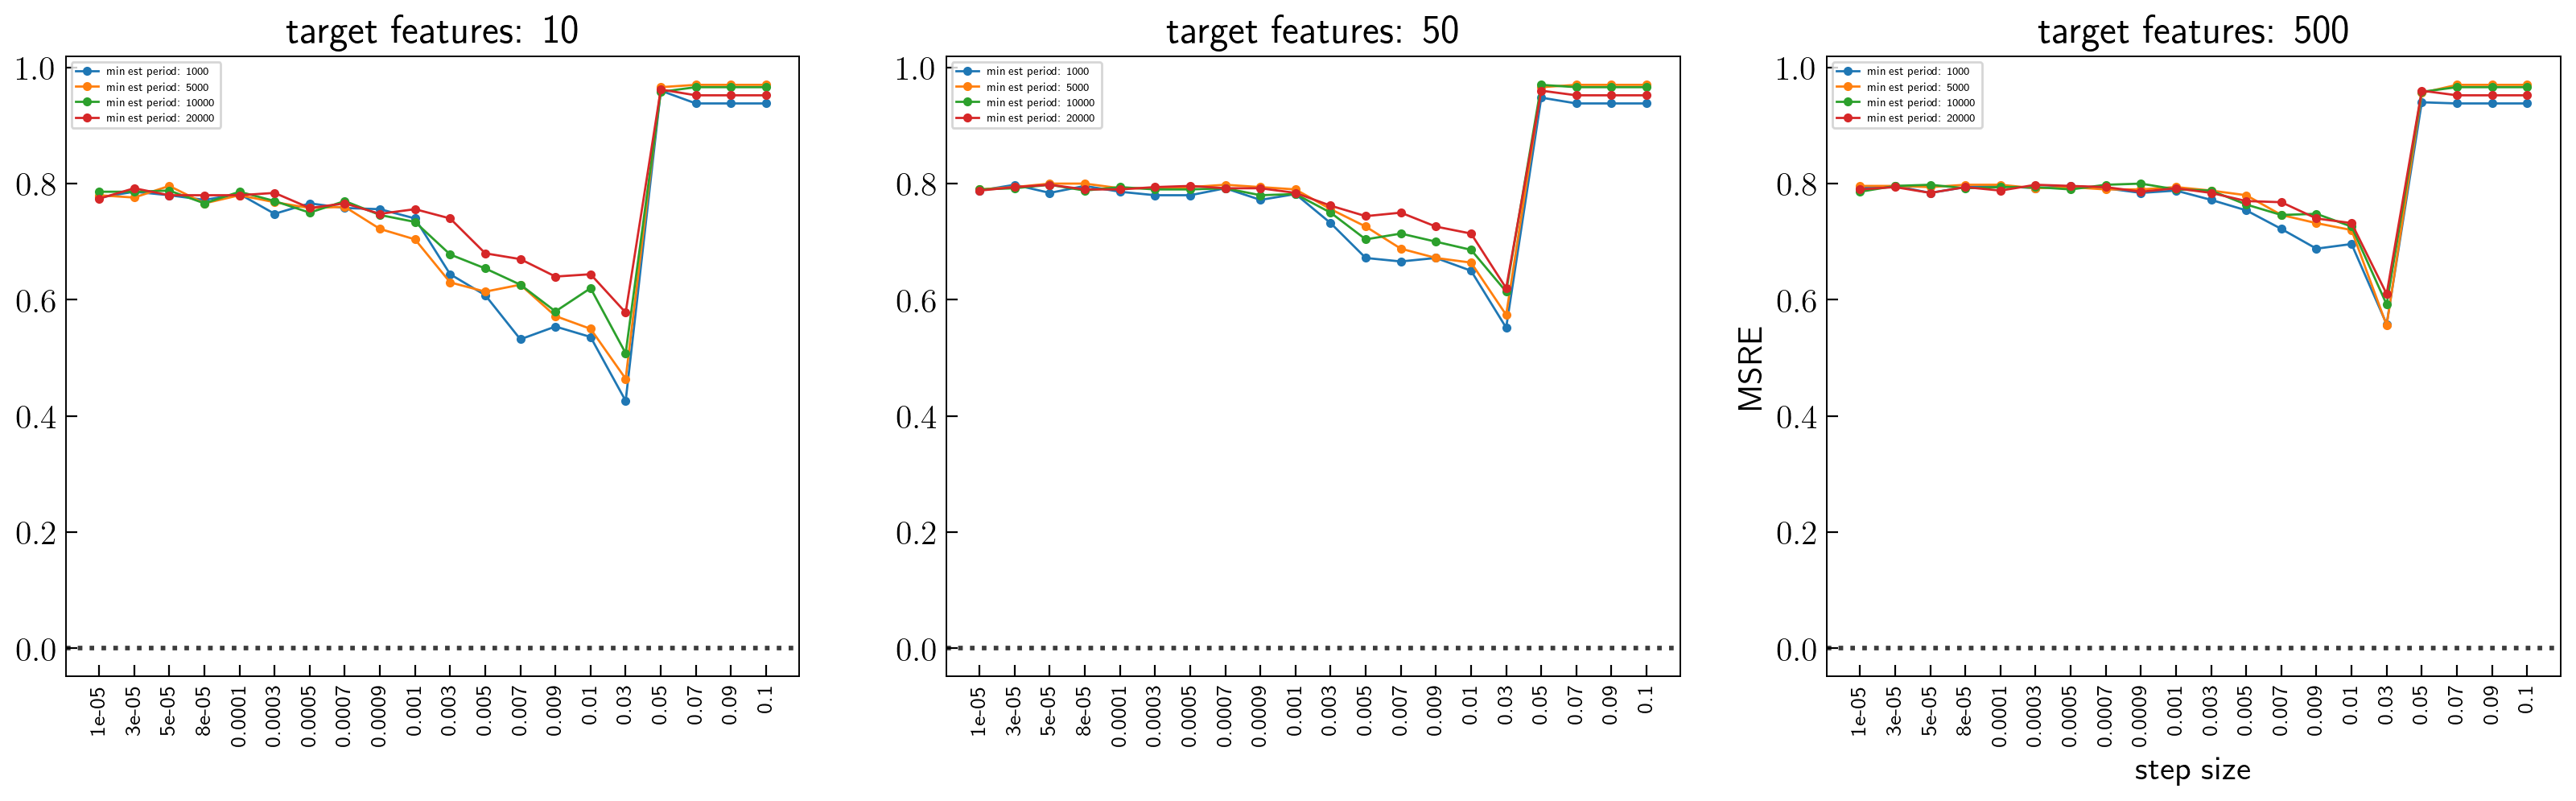

In [19]:
db=db3
total_runs_per_config = 10
markers = ['.',8,'s','p','*','h', 1,2,3,4]
marker_idx = 0
i = 0
j = 0

fig, axs = plt.subplots(1,3, figsize=(20,5), dpi=200)
plt.xlabel('step size')
plt.ylabel('MSRE')
plt.xscale('linear')
plt.xticks(rotation=90)
plt.xticks(fontsize= 5)
#fig.axes[0].set_ylim(bottom=0.002, top=0.02)
#legend = plt.legend(prop={'size': 10})
#frame = legend.get_frame()
#frame.set_linewidth(0.6)
#frame.set_boxstyle('Square')
#print(f'{"params" :^15}{"features" :^8} {"std_cap" :^10} {"all_errors":^200} {"mean" :^10} {"total runs" :^10}')
for n_target_features in [10,50,500]:
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
    color_idx = 0
    for min_estimation_period in [1000, 5000, 10000, 20000]:

        mean_errors = []
        runs = pd.read_sql(f'select run, step_size from runs where n_target_features={n_target_features} and random_thresh_decorrelate={1} and min_estimation_period={min_estimation_period}', db.conn)
        p1 = np.unique(runs.values[:,1])
        for p in p1:
            p = [p]
            all_errors = []
            r = runs[(runs["step_size"] == p[0])]
            for run in r["run"].values:
                errors_list = pd.read_sql(f'select n_mature/50 from error_table where run={run} order by step desc limit 1', db.conn).values
                all_errors.append(errors_list[0][0])
            all_errors = list(filter(lambda v: v==v, all_errors))
            if len(all_errors) >= total_runs_per_config:
                mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
            print(f'{str(p) :^30} {n_target_features :^20} {str(all_errors) :^200} {np.mean(all_errors) :^10.5f} {len(all_errors) :^10}')
        #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
        r["run"].values
        mean_errors = np.array(mean_errors)

        values = mean_errors
        axs[i].plot(values[:,0].astype('str'), values[:,1], label=f"min est period: {min_estimation_period}", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
        #axs[j].set_ylim(bottom=0.002, top=0.02)
        axs[i].axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)
        axs[i].legend(prop={'size': 5})
        axs[i].set_title(f"target features: {n_target_features}")
        axs[i].set_xticks(values[:,0].astype(str))
        axs[i].set_xticklabels(values[:,0], rotation=90, fontsize=10)
        color_idx += 1
    i+=1
    print("\n")
j+=1
i=0

plt.show()

           [1e-05]                      10                                                                               [0.0, 5.1281, 4.9999, 0.0, 5.1281, 0.0, 0.0, 5.263, 0.0, 0.0]                                                                        2.05191       10    
           [3e-05]                      10                                                                                  [0.0, 0.0, 0.0, 5.1281, 0.0, 0.0, 0.0, 9.9998, 0.0, 0.0]                                                                          1.51279       10    
           [5e-05]                      10                                                                                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.1281, 0.0, 0.0, 5.263]                                                                           1.03911       10    
           [8e-05]                      10                                                                                  [5.1281, 0.0, 0.0, 0.0, 0.0, 0.0, 5.5554, 0.0, 0.0,

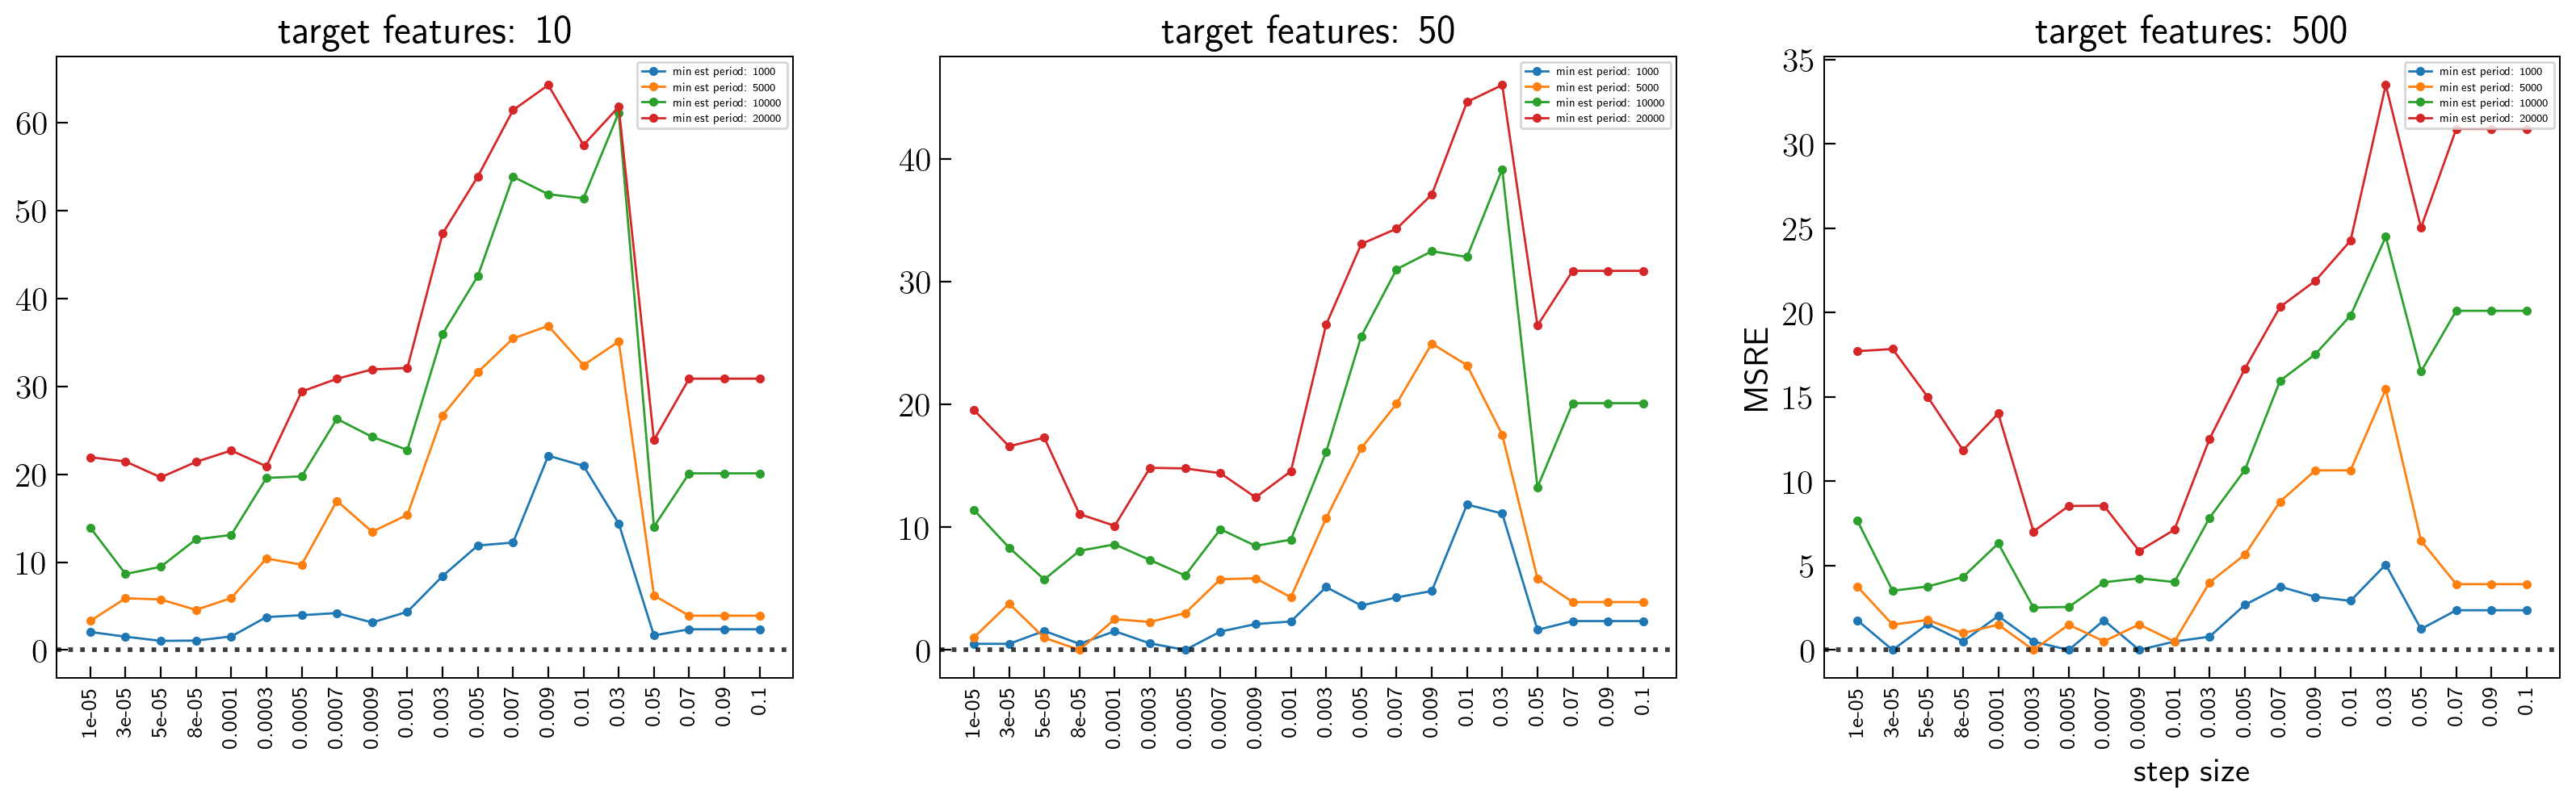

In [20]:
db=db3
total_runs_per_config = 10
markers = ['.',8,'s','p','*','h', 1,2,3,4]
marker_idx = 0
i = 0
j = 0

fig, axs = plt.subplots(1,3, figsize=(20,5), dpi=200)
plt.xlabel('step size')
plt.ylabel('MSRE')
plt.xscale('linear')
plt.xticks(rotation=90)
plt.xticks(fontsize= 5)
#fig.axes[0].set_ylim(bottom=0.002, top=0.02)
#legend = plt.legend(prop={'size': 10})
#frame = legend.get_frame()
#frame.set_linewidth(0.6)
#frame.set_boxstyle('Square')
#print(f'{"params" :^15}{"features" :^8} {"std_cap" :^10} {"all_errors":^200} {"mean" :^10} {"total runs" :^10}')
for n_target_features in [10,50,500]:
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
    color_idx = 0
    for min_estimation_period in [1000, 5000, 10000, 20000]:

        mean_errors = []
        runs = pd.read_sql(f'select run, step_size from runs where n_target_features={n_target_features} and random_thresh_decorrelate={1} and min_estimation_period={min_estimation_period}', db.conn)
        p1 = np.unique(runs.values[:,1])
        for p in p1:
            p = [p]
            all_errors = []
            r = runs[(runs["step_size"] == p[0])]
            for run in r["run"].values:
                errors_list = pd.read_sql(f'select 100*(n_correlated/(n_mature+0.001)) from error_table where run={run} order by step desc limit 1', db.conn).values
                all_errors.append(errors_list[0][0])
            all_errors = list(filter(lambda v: v==v, all_errors))
            if len(all_errors) >= total_runs_per_config:
                mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
            print(f'{str(p) :^30} {n_target_features :^20} {str(all_errors) :^200} {np.mean(all_errors) :^10.5f} {len(all_errors) :^10}')
        #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
        r["run"].values
        mean_errors = np.array(mean_errors)

        values = mean_errors
        axs[i].plot(values[:,0].astype('str'), values[:,1], label=f"min est period: {min_estimation_period}", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
        #axs[j].set_ylim(bottom=0.002, top=0.02)
        axs[i].axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)
        axs[i].legend(prop={'size': 5})
        axs[i].set_title(f"target features: {n_target_features}")
        axs[i].set_xticks(values[:,0].astype(str))
        axs[i].set_xticklabels(values[:,0], rotation=90, fontsize=10)
        color_idx += 1
    i+=1
    print("\n")
j+=1
i=0

plt.show()

In [ ]:

plt_name = f'Fixed network vs GnT'
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('MSRE')
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 0

for n_target_features in [500]:
    conditions = [["n_target_features", n_target_features],
                  ["replace_every", 2000000],
                 ['n2_decorrelate', 0],
                 ['step_size', 0.0003]]
    plt_with_err("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [No GnT]', conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
    color_idx+=1


color_idx=0
for n_target_features in [500]:
    conditions = [["n_target_features", n_target_features],
                  ["replace_every", 5000],
                 ['n2_decorrelate', 0],
                 ['step_size', 0.008]]
    plt_with_err("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [GnT]', conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle=":")
    color_idx+=1

    
legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
plt.axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
#fig.axes[0].set_ylim(top=300)
#plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

In [ ]:

plt_name = f'Fixed network vs GnT'
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('MSRE')
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 1

for n_target_features in [10,25,50,100]:
    conditions = [["n_target_features", n_target_features],
                  ["replace_every", 2000000],
                 ['n2_decorrelate', 0],
                 ['step_size', 0.0003]]
    plt_with_err("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [No GnT]', conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
    color_idx+=1


color_idx=1
for n_target_features in [10,25,50,100]:
    conditions = [["n_target_features", n_target_features],
                  ["replace_every", 5000],
                 ['n2_decorrelate', 0],
                 ['step_size', 0.008]]
    plt_with_err("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [GnT]', conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle=":")
    color_idx+=1

    
legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
plt.axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
#fig.axes[0].set_ylim(top=300)
#plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

In [ ]:

plt_name = f'Fixed network vs GnT'
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('Percentage of features correlated')
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 0

for n_target_features in [10,25,50,100, 500]:
    conditions = [["n_target_features", n_target_features],
                  ["replace_every", 2000000],
                 ['n2_decorrelate', 0],
                 ['step_size', 0.0003]]
    plt_with_err_corr("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [No GnT]', conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7, col="n_correlated")
    color_idx+=1

color_idx = 0
for n_target_features in [10,25,50,100, 500]:
    conditions = [["n_target_features", n_target_features],
                  ["replace_every", 5000],
                 ['n2_decorrelate', 0],
                 ['step_size', 0.008]]
    plt_with_err_corr("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [GnT]', conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7, col="n_correlated", linestyle=":")
    color_idx+=1

legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
plt.axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)

frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
fig.axes[0].set_ylim(top=90)
#plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()